In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer, TreebankWordTokenizer
import spacy
import matplotlib.pyplot as plt
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuxia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yuxia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yuxia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling  import  RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score

from collections import Counter

# Preprocessing Text

## 1. Tokenize reviews into words remove stop words

In [9]:
def tokenize_sentences(x, tokenizer, stop_words):
    return [word.lower() for word in tokenizer.tokenize(x) if word.lower() not in stop_words and len(word) >=2]

raw_data = pd.read_csv("../amazon-product-ratings/product_rating.csv", index_col=0).dropna()
stop_words = set(stopwords.words('english')) 

# tokenize documents into sentences
my_tokenizer = RegexpTokenizer('\w+')
# data['reviews'] = data['reviews'].apply(lambda x: tokenize_sentences(x, my_tokenizer, stop_words))

In [10]:
raw_data = pd.read_pickle('reviews.pkl')

In [11]:
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner', 'tagger'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-' and not tok.is_punct]
        tokens = [tok for tok in tokens if tok not in stop_words]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

def cleanup_text(doc):
    doc = nlp(doc, disable=['parser', 'ner', 'tagger', 'textcat'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-' and not tok.is_punct]
    tokens = [tok for tok in tokens if tok not in stop_words]
    return tokens

In [232]:
split_reviews = raw_data['reviews'].iloc[:1000].apply(cleanup_text)

Wall time: 2.95 s


In [353]:
raw_data['reviews'] = raw_data['reviews'].apply(lambda x: re.sub('[\>\<=_`\^\(\)&!@:#$;,\.\+-/\d]', '', x))

In [354]:

split_reviews = []
for doc in nlp.pipe(raw_data['reviews'].tolist(), disable=['parser', 'ner', 'tagger', 'textcat']):
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-' and (not tok.is_punct) and (not tok.is_space) and (not tok.like_num)]
    tokens = [tok for tok in tokens if tok not in stop_words]
    split_reviews.append(tokens)


In [355]:
raw_data['split_reviews'] = split_reviews

## 2. Train a Doc2Vec model

In [12]:
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split

C:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [24]:
documents = raw_data['split_reviews'].tolist()
train_corpus, test_corpus, y_train, y_test = train_test_split(raw_data['split_reviews'], raw_data['ratings'].values, test_size=0.33, random_state=42)
# test_corpus = [x.words for x in test_corpus] # we only want words for test corpus

In [445]:
ratings_one_num = (raw_data['ratings'] == 1).sum()

4701

In [108]:
n_dim = 100
epochs = 10
model = Word2Vec(documents, size=n_dim, min_count=2, workers=8)

model.train(documents, total_examples=len(documents), epochs=epochs)

(69246131, 79723620)

In [521]:
sentimental_words = neg_words + pos_words

In [5]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * 1
            count += 1
        except KeyError: # handling the case where the token is not in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

# Random sampling same amount of type of documents

In [505]:
rating_one_index = raw_data[raw_data['ratings'] == 1].index
num_to_sample = len(rating_one_index)

sample_indices = []
for rating in range(1, 6):
    indices = raw_data[raw_data['ratings'] == rating].index
    sample_indices.append(np.random.choice(indices, num_to_sample))
sample_indices = np.array(sample_indices)
sample_indices = sample_indices.reshape((sample_indices.shape[0] * sample_indices.shape[1], ))

In [512]:
sample_documents = raw_data.loc[sample_indices]['split_reviews'].tolist()

In [14]:
documents = raw_data['split_reviews'].tolist()
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform(documents)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [13]:
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords

In [607]:
w2v_features = np.concatenate([buildWordVector(tokens, n_dim) for tokens in documents])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [608]:
w2v_features = pd.DataFrame(w2v_features)

In [609]:
raw_data = raw_data.drop(w2v_feature_col, axis=1)

In [610]:
raw_data = raw_data.reset_index().drop('index', axis=1)
raw_data = pd.concat([raw_data, w2v_features],axis=1)

# 3 Train a simple model

In [114]:
train_tags = [x.tags for x in train_corpus]
test_tags = [x.tags for x in test_corpus]

X_train = model[train_tags]
X_test = model[test_tags]

In [115]:
sampler = RandomUnderSampler()
X_train_res, y_train_res = sampler.fit_resample(X_train, y)
clf = AdaBoostClassifier()
clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [124]:
sampler = RandomUnderSampler()
X_train_res, y_train_res = sampler.fit_resample(X_train, y)
clf = AdaBoostClassifier()
clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [125]:
print(classification_report_imbalanced(clf.predict(X_test), y_test))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.33      0.05      0.98      0.09      0.23      0.05      9625
        2.0       0.19      0.07      0.97      0.10      0.26      0.06      5790
        3.0       0.28      0.16      0.91      0.20      0.38      0.13      9559
        4.0       0.17      0.28      0.78      0.21      0.47      0.21      7502
        5.0       0.50      0.75      0.48      0.60      0.60      0.37     22801

avg / total       0.36      0.39      0.73      0.34      0.44      0.22     55277



In [585]:
print([tfidf[word] for word in documents[0]])
print(documents[0])

[2.106728176195469, 3.801681369215963, 3.2644383320221495, 4.874695580839653, 3.0019480753660073, 5.539558047561015, 3.0019480753660073, 5.024756275415386]
['like', 'item', 'price', 'granddaughter', 'want', 'mark', 'want', 'letter']


# Feature Extraction

In [418]:
with open("../amazon-product-ratings/positive-words.txt") as f1:
    pos_words = f1.read().split('\n')
pos_words = pos_words[:-1]

with open("../amazon-product-ratings/negative-words.txt") as f2:
    neg_words = f2.read().split('\n')
neg_words = neg_words[:-1]

pos_words = pd.Series(pos_words).str.lower().tolist()
neg_words = pd.Series(neg_words).str.lower().tolist()

# Using Spark count sentimental words

In [57]:
raw_data['reviews'] = raw_data['reviews'].str.lower()
# raw_data['split_reviews'] = raw_data['reviews'].apply(lambda x: my_tokenizer.tokenize(x))

In [58]:
from operator import add
rdd = sc.parallelize(raw_data['reviews'].dropna().values)
pos_words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in pos_words])).collect()
neg_words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in neg_words])).collect()

raw_data['pos_words_count'] = pos_words_count
raw_data['neg_words_count'] = neg_words_count
raw_data['review_length'] = raw_data['reviews'].apply(lambda x: len(my_tokenizer.tokenize(x)))

# Some Visulization
## We discvoer that in the reviews, sentiment words are highly correlated with the ratings

more negative words, means lower the ratings
more positive words, mean higher the ratings

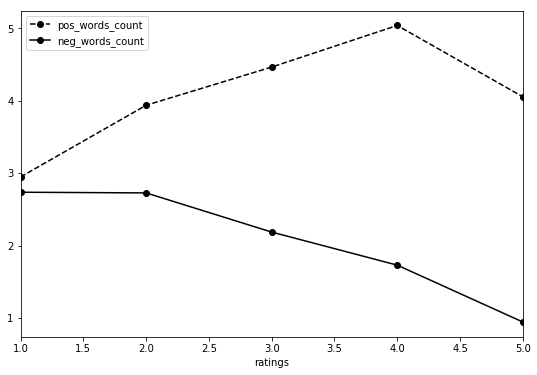

In [478]:
plt.tight_layout()
raw_data.groupby('ratings').agg({'pos_words_count': 'mean',
                                'neg_words_count': 'mean'}).plot(figsize=(9, 6), style=['--', '-'], color=['black', 'black'], marker='o')

# negation in the sentences should be taken care of!

"My little man got this for his first birthday along with the base. Now at 18 months he drags it back into the family room if we move it.  He loves his pony and will climb on and off all on his own whenever the mood strikes him. The base does make it very stable for younger kids and has not once tipped over. I have only had to add more air once to get the pressure back up, **not ** bad considering he has used it daily for half a year. We have the green with blue saddle and colors online are very true (assuming your monitor is).Rody has survived many a chomp on the ears and tail during rough teething times, but between us catching our little culprit and the thickness of the rubber it has not sustained any damage. Rody continues to look overjoyed to see our Son regardless of the abuse and I'm sure will be part of the family for a long time."

In [205]:
[word for word in my_tokenizer.tokenize(raw_data.loc[8781]['reviews']) if word in neg_words]

['drags', 'bad', 'rough', 'culprit', 'damage', 'abuse']

# Reviews length

It's reasonable to say, people tend to give longer reviews when they are angry or really hate the product, and tend to give shorter reviews when they are satisifed with the product

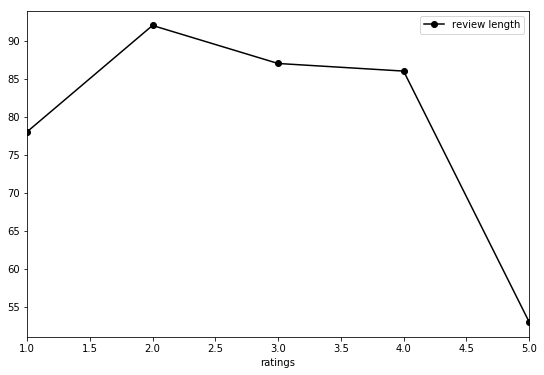

In [479]:
import seaborn
raw_data.groupby('ratings').review_length.median().plot(figsize=(9, 6), color='black', marker='o')
plt.legend(["review length"])

In [430]:
documents

1.9122393694260618

# Train a simple model based on sentimental words count

We decided to use mean absolute error as the metric to evaluate our model

$score = \sum_{i=1}^{n}|\hat{y_i} - y_i| $

Right now, our simple model, on average, predicts one rating away from the true rating

In [661]:
w2v_feature_col = list(range(100))
features_data = raw_data[['ratings'] + w2v_feature_col]
X = features_data[w2v_feature_col]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y)

sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
# clf = AdaBoostClassifier(n_estimators=100)
# clf.fit(X_train_res, y_train_res)

# mean_absolute_error(clf.predict(X_val), y_val)

In [488]:
print(classification_report_imbalanced(y_val, clf.predict(X_val)))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.57      0.09      0.99      0.15      0.29      0.08     10341
        2.0       0.13      0.08      0.97      0.10      0.27      0.07      3526
        3.0       0.11      0.13      0.91      0.12      0.34      0.10      4768
        4.0       0.29      0.28      0.79      0.29      0.47      0.21     12563
        5.0       0.53      0.75      0.49      0.62      0.61      0.38     24079

avg / total       0.42      0.42      0.72      0.38      0.47      0.24     55277



In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

w2v_feature_col = list(range(100))
features_data = raw_data[['ratings'] + w2v_feature_col]
X = features_data[w2v_feature_col]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y)

sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)

nn = Sequential()
nn.add(Dense(16, activation='relu', input_dim=100))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(5, activation='softmax'))
nn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

nn.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10
344165/344165 [==============================] - ETA: 21:06 - loss: 1.6469 - mean_absolute_error: 0.31 - ETA: 27s - loss: 1.5011 - mean_absolute_error: 0.3022 - ETA: 15s - loss: 1.4319 - mean_absolute_error: 0.29 - ETA: 11s - loss: 1.3885 - mean_absolute_error: 0.28 - ETA: 9s - loss: 1.3558 - mean_absolute_error: 0.2785 - ETA: 7s - loss: 1.3305 - mean_absolute_error: 0.274 - ETA: 6s - loss: 1.3122 - mean_absolute_error: 0.271 - ETA: 6s - loss: 1.2988 - mean_absolute_error: 0.268 - ETA: 5s - loss: 1.2867 - mean_absolute_error: 0.266 - ETA: 5s - loss: 1.2768 - mean_absolute_error: 0.265 - ETA: 5s - loss: 1.2687 - mean_absolute_error: 0.263 - ETA: 4s - loss: 1.2625 - mean_absolute_error: 0.262 - ETA: 4s - loss: 1.2543 - mean_absolute_error: 0.261 - ETA: 4s - loss: 1.2492 - mean_absolute_error: 0.260 - ETA: 4s - loss: 1.2445 - mean_absolute_error: 0.259 - ETA: 3s - loss: 1.2400 - mean_absolute_error: 0.258 - ETA: 3s - loss: 1.2356 - mean_absolute_error: 0.258 - ETA: 3s - loss: 1

344165/344165 [==============================] - ETA: 37s - loss: 0.8910 - mean_absolute_error: 0.20 - ETA: 3s - loss: 1.0371 - mean_absolute_error: 0.2214 - ETA: 2s - loss: 1.0342 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0354 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0350 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0367 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0367 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0372 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0412 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0415 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0399 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0411 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0408 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0423 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0419 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0426 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0417 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0429 - mean_ab

344165/344165 [==============================] - ETA: 30s - loss: 0.9686 - mean_absolute_error: 0.21 - ETA: 3s - loss: 1.0106 - mean_absolute_error: 0.2156 - ETA: 2s - loss: 1.0019 - mean_absolute_error: 0.213 - ETA: 2s - loss: 1.0163 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0140 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0133 - mean_absolute_error: 0.216 - ETA: 2s - loss: 1.0137 - mean_absolute_error: 0.216 - ETA: 2s - loss: 1.0118 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0120 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0108 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0112 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0116 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0106 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 1s - loss: 1.0117 - mean_ab

In [71]:
y_pred_nn = nn.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.6581580042332253

In [18]:
from keras.optimizers import adam
nn = Sequential()
nn.add(Dense(16, activation='relu', input_dim=100))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(5, activation='softmax'))

optimizer = adam(lr=0.0005)
nn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=2)]

nn.fit(X_train_res[:500, :], y_train_nn_res.iloc[:500], epochs=20, batch_size=10,callbacks=callbacks)

Epoch 1/20
500/500 [==============================] - ETA: 12s - loss: 1.8919 - mean_absolute_error: 0.30 - 0s 584us/step - loss: 1.3626 - mean_absolute_error: 0.2562
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 1.2810 - mean_absolute_error: 0.217 - 0s 74us/step - loss: 1.0589 - mean_absolute_error: 0.2171
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.9835 - mean_absolute_error: 0.214 - 0s 74us/step - loss: 0.9998 - mean_absolute_error: 0.2051
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 1.0682 - mean_absolute_error: 0.236 - 0s 74us/step - loss: 0.9498 - mean_absolute_error: 0.2008
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 0.9160 - mean_absolute_error: 0.200 - 0s 74us/step - loss: 0.9126 - mean_absolute_error: 0.1939
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 0.6554 - mean_absolute_error: 0.153 - 0s 76us/step - loss: 0.8761 - mean_absolute_error: 0.1857
Epo

In [19]:
y_pred_nn = nn.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.6111221665430469

In [69]:
print(classification_report_imbalanced(y_val, y_pred_nn))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.19      0.21      0.97      0.20      0.46      0.19      1551
        2.0       0.19      0.13      0.98      0.16      0.36      0.12      2076
        3.0       0.30      0.29      0.93      0.30      0.52      0.25      5395
        4.0       0.36      0.35      0.82      0.36      0.54      0.27     12352
        5.0       0.76      0.78      0.61      0.77      0.69      0.48     33903

avg / total       0.59      0.60      0.71      0.59      0.62      0.39     55277



In [591]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

w2v_feature_col = list(range(100))
simple_feature_col = ['pos_words_count', 'neg_words_count', 'review_length']
y_col = ['ratings']
features_data = raw_data[simple_feature_col + y_col]
X = features_data[simple_feature_col]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y)

sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)


nn = Sequential()
nn.add(Dense(16, activation='relu', input_dim=3))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(5, activation='softmax'))
nn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

nn.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10
344165/344165 [==============================] - ETA: 50:53 - loss: 6.2571 - mean_absolute_error: 0.32 - ETA: 1:06 - loss: 2.7771 - mean_absolute_error: 0.3200 - ETA: 37s - loss: 2.3174 - mean_absolute_error: 0.319 - ETA: 25s - loss: 2.1165 - mean_absolute_error: 0.31 - ETA: 19s - loss: 2.0179 - mean_absolute_error: 0.31 - ETA: 16s - loss: 1.9612 - mean_absolute_error: 0.31 - ETA: 14s - loss: 1.9217 - mean_absolute_error: 0.31 - ETA: 12s - loss: 1.8950 - mean_absolute_error: 0.31 - ETA: 11s - loss: 1.8721 - mean_absolute_error: 0.31 - ETA: 10s - loss: 1.8483 - mean_absolute_error: 0.31 - ETA: 9s - loss: 1.8328 - mean_absolute_error: 0.3159 - ETA: 8s - loss: 1.8191 - mean_absolute_error: 0.315 - ETA: 7s - loss: 1.8052 - mean_absolute_error: 0.315 - ETA: 7s - loss: 1.7952 - mean_absolute_error: 0.315 - ETA: 7s - loss: 1.7850 - mean_absolute_error: 0.314 - ETA: 6s - loss: 1.7750 - mean_absolute_error: 0.314 - ETA: 6s - loss: 1.7657 - mean_absolute_error: 0.314 - ETA: 6s - loss:

344165/344165 [==============================] - ETA: 37s - loss: 1.5321 - mean_absolute_error: 0.30 - ETA: 4s - loss: 1.4730 - mean_absolute_error: 0.2959 - ETA: 3s - loss: 1.4801 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4823 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4797 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4786 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4795 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4783 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4783 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4783 - mean_ab

344165/344165 [==============================] - ETA: 31s - loss: 1.5359 - mean_absolute_error: 0.30 - ETA: 4s - loss: 1.4738 - mean_absolute_error: 0.2982 - ETA: 3s - loss: 1.4629 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4645 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4672 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4675 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4678 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4670 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4666 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4675 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4670 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4660 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4656 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4663 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4659 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4655 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4651 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4653 - mean_ab

# LSTM and CNN

In [135]:
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, Dropout, MaxPooling1D, LSTM, Flatten, Dense, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [86]:
documents = raw_data['split_reviews'].tolist()
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform(documents)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [117]:

vocab_size = len(tfidf) + 1

keras_tokenizer = Tokenizer(num_words=vocab_size)
keras_tokenizer.fit_on_texts(raw_data['split_reviews'])


seq = keras_tokenizer.texts_to_sequences(raw_data['split_reviews'])
new_data = pad_sequences(seq, maxlen=50)

y = raw_data['ratings']
X_train, X_val, y_train, y_val = train_test_split(new_data, y, test_size=0.33, stratify=y)
sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)

In [119]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 100, input_length=50))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(5, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', 
                   optimizer='adam',    
                   metrics=['mae'])
model_conv.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

y_pred_nn = model_conv.predict_classes(X_val) + 1
mae = mean_absolute_error(y_pred_nn, y_val)

Epoch 1/10


 17100/344165 [>.............................] - ETA: 1:23:18 - loss: 1.6095 - mean_absolute_error: 0.32 - ETA: 43:12 - loss: 1.6098 - mean_absolute_error: 0.3200 - ETA: 29:53 - loss: 1.6103 - mean_absolute_error: 0.32 - ETA: 23:12 - loss: 1.6102 - mean_absolute_error: 0.32 - ETA: 19:11 - loss: 1.6132 - mean_absolute_error: 0.32 - ETA: 16:30 - loss: 1.6131 - mean_absolute_error: 0.32 - ETA: 14:36 - loss: 1.6117 - mean_absolute_error: 0.32 - ETA: 13:10 - loss: 1.6110 - mean_absolute_error: 0.32 - ETA: 12:05 - loss: 1.6102 - mean_absolute_error: 0.32 - ETA: 11:10 - loss: 1.6107 - mean_absolute_error: 0.32 - ETA: 10:26 - loss: 1.6106 - mean_absolute_error: 0.32 - ETA: 9:16 - loss: 1.6100 - mean_absolute_error: 0.3200 - ETA: 8:52 - loss: 1.6090 - mean_absolute_error: 0.319 - ETA: 8:28 - loss: 1.6081 - mean_absolute_error: 0.319 - ETA: 7:47 - loss: 1.6070 - mean_absolute_error: 0.319 - ETA: 7:30 - loss: 1.6066 - mean_absolute_error: 0.319 - ETA: 7:17 - loss: 1.6061 - mean_absolute_error: 0.

148600/344165 [===========>..................] - ETA: 1:53 - loss: 1.3919 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3918 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3917 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3917 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3917 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3916 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3916 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3914 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3913 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3913 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3910 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3911 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3910 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3909 - mean_absolute_error: 0.285 - ETA: 1:51 - loss: 1.3909 - mean_absolute_error: 0.285 - ETA: 1:51 - loss: 1.3908 - mean_absolute_error: 0.285 - ETA: 1:51 - loss: 1.3907 - mean_absolute_error: 0.285 -

167500/344165 [=============>................] - ETA: 1:42 - loss: 1.3815 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3815 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3813 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3812 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3811 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3811 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3810 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3809 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3809 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3808 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3808 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3808 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3807 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3806 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3804 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3804 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3802 - mean_absolute_error: 0.283 -

184900/344165 [===============>..............] - ETA: 1:32 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:32 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:32 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3729 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3728 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3726 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3725 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3724 - mean_absolute_error: 0.282 - ETA: 1:30 - loss: 1.3724 - mean_absolute_error: 0.282 - ETA: 1:30 - loss: 1.3723 - mean_absolute_error: 0.282 -

200200/344165 [================>.............] - ETA: 1:23 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3663 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3663 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3663 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3662 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3662 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3661 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3661 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3660 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3660 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 -

215200/344165 [=================>............] - ETA: 1:15 - loss: 1.3615 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3615 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3614 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3613 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3613 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3612 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3612 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3612 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3610 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3610 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3610 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3609 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3609 - mean_absolute_error: 0.280 -

235000/344165 [===================>..........] - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3568 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3566 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3565 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3565 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3563 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3562 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3562 - mean_absolute_error: 0.280 - ETA: 1:06 - loss: 1.3562 - mean_absolute_error: 0.280 -

253700/344165 [=====================>........] - ETA: 57s - loss: 1.3509 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3509 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3508 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3508 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3506 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3506 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3506 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3505 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3505 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3505 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3504 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3504 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3503 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3503 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3502 - mean_ab

271400/344165 [======================>.......] - ETA: 47s - loss: 1.3462 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3460 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3460 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3458 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3458 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3458 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3457 - mean_ab

289800/344165 [========================>.....] - ETA: 38s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3414 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3414 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3412 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3412 - mean_absolute_error: 0.27 - ETA: 36s - loss: 1.3412 - mean_ab

309200/344165 [=========================>....] - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3373 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3373 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3373 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3370 - mean_ab

327000/344165 [===========================>..] - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3333 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3333 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.3304 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3304 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 7s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 7s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 7s - loss: 1.3301 - mean_abs

 19000/344165 [>.............................] - ETA: 3:15 - loss: 1.2354 - mean_absolute_error: 0.268 - ETA: 2:49 - loss: 1.2571 - mean_absolute_error: 0.270 - ETA: 2:43 - loss: 1.2453 - mean_absolute_error: 0.267 - ETA: 2:40 - loss: 1.2349 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2280 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2391 - mean_absolute_error: 0.267 - ETA: 2:37 - loss: 1.2425 - mean_absolute_error: 0.267 - ETA: 2:37 - loss: 1.2361 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2368 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2364 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2366 - mean_absolute_error: 0.265 - ETA: 2:35 - loss: 1.2401 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2386 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2484 - mean_absolute_error: 0.266 - ETA: 2:39 - loss: 1.2493 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2493 - mean_absolute_error: 0.267 - ETA: 2:38 - loss: 1.2455 - mean_absolute_error: 0.266 -

150900/344165 [============>.................] - ETA: 1:47 - loss: 1.2301 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2300 - mean_absolute_error: 0.261 -

168500/344165 [=============>................] - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2298 - mean_absolute_error: 0.261 -

188000/344165 [===============>..............] - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2304 - mean_absolute_error: 0.261 -

209800/344165 [=================>............] - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2310 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2307 - mean_absolute_error: 0.261 -

228100/344165 [==================>...........] - ETA: 1:07 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 -

246400/344165 [====================>.........] - ETA: 58s - loss: 1.2310 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2310 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2310 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2307 - mean_ab

269300/344165 [======================>.......] - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2303 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2303 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2303 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_ab

288400/344165 [========================>.....] - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_ab

307000/344165 [=========================>....] - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2307 - mean_ab

328200/344165 [===========================>..] - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2304 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2305 - mean_abs

 21800/344165 [>.............................] - ETA: 3:19 - loss: 1.2432 - mean_absolute_error: 0.265 - ETA: 3:08 - loss: 1.2296 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2065 - mean_absolute_error: 0.259 - ETA: 3:04 - loss: 1.2016 - mean_absolute_error: 0.257 - ETA: 3:02 - loss: 1.2031 - mean_absolute_error: 0.258 - ETA: 3:01 - loss: 1.1855 - mean_absolute_error: 0.256 - ETA: 2:55 - loss: 1.1804 - mean_absolute_error: 0.256 - ETA: 2:57 - loss: 1.1823 - mean_absolute_error: 0.256 - ETA: 2:53 - loss: 1.1865 - mean_absolute_error: 0.257 - ETA: 2:51 - loss: 1.1760 - mean_absolute_error: 0.256 - ETA: 2:51 - loss: 1.1729 - mean_absolute_error: 0.255 - ETA: 2:50 - loss: 1.1694 - mean_absolute_error: 0.255 - ETA: 2:49 - loss: 1.1696 - mean_absolute_error: 0.255 - ETA: 2:47 - loss: 1.1697 - mean_absolute_error: 0.255 - ETA: 2:46 - loss: 1.1689 - mean_absolute_error: 0.255 - ETA: 2:45 - loss: 1.1660 - mean_absolute_error: 0.254 - ETA: 2:45 - loss: 1.1622 - mean_absolute_error: 0.253 -

169900/344165 [=============>................] - ETA: 1:33 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1799 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1799 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1799 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1801 - mean_absolute_error: 0.253 -

186000/344165 [===============>..............] - ETA: 1:25 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 -

204000/344165 [================>.............] - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1820 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1821 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1821 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1821 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1822 - mean_absolute_error: 0.253 -

222800/344165 [==================>...........] - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 -

240500/344165 [===================>..........] - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1833 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1833 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 59s - loss: 1.1831 - mean_absolute_error: 0.253 - 

263700/344165 [=====================>........] - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_ab

283100/344165 [=======================>......] - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1849 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1849 - mean_ab

299800/344165 [=========================>....] - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1859 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1859 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1859 - mean_ab

317300/344165 [==========================>...] - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_ab

336400/344165 [============================>.] - ETA: 13s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1866 - mean_ab

344165/344165 [==============================] - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 2s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 2s - loss: 1.1870 - mean_abs

 15500/344165 [>.............................] - ETA: 3:29 - loss: 1.2178 - mean_absolute_error: 0.266 - ETA: 3:12 - loss: 1.1766 - mean_absolute_error: 0.257 - ETA: 3:16 - loss: 1.1346 - mean_absolute_error: 0.251 - ETA: 3:11 - loss: 1.1428 - mean_absolute_error: 0.253 - ETA: 3:08 - loss: 1.1335 - mean_absolute_error: 0.251 - ETA: 3:08 - loss: 1.1409 - mean_absolute_error: 0.252 - ETA: 3:01 - loss: 1.1271 - mean_absolute_error: 0.250 - ETA: 3:01 - loss: 1.1246 - mean_absolute_error: 0.248 - ETA: 3:01 - loss: 1.1300 - mean_absolute_error: 0.249 - ETA: 3:01 - loss: 1.1234 - mean_absolute_error: 0.247 - ETA: 3:02 - loss: 1.1351 - mean_absolute_error: 0.248 - ETA: 3:02 - loss: 1.1423 - mean_absolute_error: 0.249 - ETA: 3:02 - loss: 1.1513 - mean_absolute_error: 0.251 - ETA: 3:03 - loss: 1.1546 - mean_absolute_error: 0.251 - ETA: 3:04 - loss: 1.1562 - mean_absolute_error: 0.251 - ETA: 3:04 - loss: 1.1521 - mean_absolute_error: 0.250 - ETA: 3:04 - loss: 1.1550 - mean_absolute_error: 0.251 -

131300/344165 [==========>...................] - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1427 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1427 - mean_absolute_error: 0.246 -

147000/344165 [===========>..................] - ETA: 1:52 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 -

165800/344165 [=============>................] - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 -

184500/344165 [===============>..............] - ETA: 1:34 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 -

208100/344165 [=================>............] - ETA: 1:24 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:22 - loss: 1.1461 - mean_absolute_error: 0.247 -

227700/344165 [==================>...........] - ETA: 1:11 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 -

253300/344165 [=====================>........] - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1471 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1472 - mean_absolute_error: 0.24 - ETA: 59s - los

272700/344165 [======================>.......] - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1488 - mean_ab

289800/344165 [========================>.....] - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_ab

305300/344165 [=========================>....] - ETA: 28s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1497 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1497 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1497 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1500 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1500 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_ab

321200/344165 [==========================>...] - ETA: 20s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 20s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1507 - mean_ab

337400/344165 [============================>.] - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_ab

344165/344165 [==============================] - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_abs

 15100/344165 [>.............................] - ETA: 3:29 - loss: 1.1974 - mean_absolute_error: 0.252 - ETA: 3:17 - loss: 1.2003 - mean_absolute_error: 0.254 - ETA: 3:10 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 3:06 - loss: 1.1835 - mean_absolute_error: 0.250 - ETA: 3:04 - loss: 1.1684 - mean_absolute_error: 0.250 - ETA: 3:03 - loss: 1.1546 - mean_absolute_error: 0.248 - ETA: 3:03 - loss: 1.1515 - mean_absolute_error: 0.248 - ETA: 3:02 - loss: 1.1446 - mean_absolute_error: 0.247 - ETA: 3:02 - loss: 1.1425 - mean_absolute_error: 0.247 - ETA: 3:02 - loss: 1.1351 - mean_absolute_error: 0.246 - ETA: 3:02 - loss: 1.1202 - mean_absolute_error: 0.244 - ETA: 3:02 - loss: 1.1200 - mean_absolute_error: 0.244 - ETA: 3:01 - loss: 1.1120 - mean_absolute_error: 0.243 - ETA: 3:01 - loss: 1.1096 - mean_absolute_error: 0.243 - ETA: 3:02 - loss: 1.1154 - mean_absolute_error: 0.244 - ETA: 3:02 - loss: 1.1193 - mean_absolute_error: 0.244 - ETA: 3:02 - loss: 1.1161 - mean_absolute_error: 0.244 -

141200/344165 [===========>..................] - ETA: 1:55 - loss: 1.1031 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1033 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1033 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1033 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1034 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1035 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1034 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1036 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1036 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1037 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1037 - mean_absolute_error: 0.239 -

159400/344165 [============>.................] - ETA: 1:46 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:46 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1055 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1055 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1056 - mean_absolute_error: 0.239 -

179300/344165 [==============>...............] - ETA: 1:36 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1069 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1069 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1069 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1070 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1070 - mean_absolute_error: 0.239 -

200500/344165 [================>.............] - ETA: 1:25 - loss: 1.1083 - mean_absolute_error: 0.239 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.239 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 -

222300/344165 [==================>...........] - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:12 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:12 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:12 - loss: 1.1095 - mean_absolute_error: 0.240 -

244700/344165 [====================>.........] - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 -

268200/344165 [======================>.......] - ETA: 50s - loss: 1.1121 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1121 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1125 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1125 - mean_ab

288100/344165 [========================>.....] - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1137 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1137 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1137 - mean_ab

311200/344165 [==========================>...] - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 26s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 26s - loss: 1.1148 - mean_ab

328000/344165 [===========================>..] - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1161 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1160 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 8s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 8s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 8s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_abs

 19600/344165 [>.............................] - ETA: 3:15 - loss: 1.0966 - mean_absolute_error: 0.243 - ETA: 2:53 - loss: 1.1154 - mean_absolute_error: 0.241 - ETA: 3:07 - loss: 1.1102 - mean_absolute_error: 0.240 - ETA: 2:56 - loss: 1.0681 - mean_absolute_error: 0.233 - ETA: 3:00 - loss: 1.0649 - mean_absolute_error: 0.234 - ETA: 2:57 - loss: 1.0742 - mean_absolute_error: 0.236 - ETA: 2:53 - loss: 1.0764 - mean_absolute_error: 0.237 - ETA: 2:53 - loss: 1.0773 - mean_absolute_error: 0.237 - ETA: 2:54 - loss: 1.0852 - mean_absolute_error: 0.238 - ETA: 2:55 - loss: 1.0831 - mean_absolute_error: 0.238 - ETA: 2:55 - loss: 1.0838 - mean_absolute_error: 0.238 - ETA: 2:58 - loss: 1.0801 - mean_absolute_error: 0.238 - ETA: 2:59 - loss: 1.0799 - mean_absolute_error: 0.238 - ETA: 2:59 - loss: 1.0756 - mean_absolute_error: 0.238 - ETA: 3:00 - loss: 1.0742 - mean_absolute_error: 0.238 - ETA: 3:00 - loss: 1.0749 - mean_absolute_error: 0.238 - ETA: 3:01 - loss: 1.0730 - mean_absolute_error: 0.238 -

147200/344165 [===========>..................] - ETA: 1:51 - loss: 1.0699 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0699 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0700 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0700 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0704 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:49 - loss: 1.0700 - mean_absolute_error: 0.232 -

162800/344165 [=============>................] - ETA: 1:42 - loss: 1.0716 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0716 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0720 - mean_absolute_error: 0.233 - ETA: 1:42 - loss: 1.0720 - mean_absolute_error: 0.233 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.233 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 -

183100/344165 [==============>...............] - ETA: 1:35 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0726 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0726 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0726 - mean_absolute_error: 0.233 -

207000/344165 [=================>............] - ETA: 1:24 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:24 - loss: 1.0732 - mean_absolute_error: 0.233 - ETA: 1:24 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0732 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0733 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0733 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0733 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0734 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0736 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0736 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 -

228600/344165 [==================>...........] - ETA: 1:10 - loss: 1.0749 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0749 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0750 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0750 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 -

252300/344165 [====================>.........] - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0755 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0755 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0757 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0757 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0758 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0758 - mean_ab

276500/344165 [=======================>......] - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0770 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0770 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_ab

300100/344165 [=========================>....] - ETA: 34s - loss: 1.0781 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0783 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0783 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_ab

322200/344165 [===========================>..] - ETA: 22s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 22s - loss: 1.0798 - mean_absolute_error: 0.23 - ETA: 22s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0798 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0798 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0799 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0799 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0799 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0800 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0800 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0800 - mean_ab

341500/344165 [============================>.] - ETA: 11s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_ab

344165/344165 [==============================] - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0826 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0826 - mean_abs

 18400/344165 [>.............................] - ETA: 3:25 - loss: 0.9746 - mean_absolute_error: 0.224 - ETA: 2:51 - loss: 1.0448 - mean_absolute_error: 0.238 - ETA: 2:52 - loss: 1.0520 - mean_absolute_error: 0.237 - ETA: 2:54 - loss: 1.0605 - mean_absolute_error: 0.238 - ETA: 2:46 - loss: 1.0719 - mean_absolute_error: 0.239 - ETA: 2:49 - loss: 1.0580 - mean_absolute_error: 0.236 - ETA: 2:53 - loss: 1.0522 - mean_absolute_error: 0.235 - ETA: 2:51 - loss: 1.0404 - mean_absolute_error: 0.233 - ETA: 2:51 - loss: 1.0380 - mean_absolute_error: 0.233 - ETA: 2:52 - loss: 1.0377 - mean_absolute_error: 0.233 - ETA: 2:55 - loss: 1.0451 - mean_absolute_error: 0.234 - ETA: 2:55 - loss: 1.0365 - mean_absolute_error: 0.232 - ETA: 2:55 - loss: 1.0330 - mean_absolute_error: 0.232 - ETA: 2:53 - loss: 1.0372 - mean_absolute_error: 0.232 - ETA: 2:54 - loss: 1.0381 - mean_absolute_error: 0.232 - ETA: 2:52 - loss: 1.0315 - mean_absolute_error: 0.231 - ETA: 2:52 - loss: 1.0265 - mean_absolute_error: 0.230 -

146700/344165 [===========>..................] - ETA: 1:50 - loss: 1.0316 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0316 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0316 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:49 - loss: 1.0313 - mean_absolute_error: 0.224 - ETA: 1:49 - loss: 1.0312 - mean_absolute_error: 0.224 -

163000/344165 [=============>................] - ETA: 1:42 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0334 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0334 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0331 - mean_absolute_error: 0.225 -

178400/344165 [==============>...............] - ETA: 1:34 - loss: 1.0336 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0338 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0338 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0338 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 -

198000/344165 [================>.............] - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0357 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0357 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0359 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0359 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0360 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0361 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0361 - mean_absolute_error: 0.225 -

216000/344165 [=================>............] - ETA: 1:16 - loss: 1.0377 - mean_absolute_error: 0.225 - ETA: 1:16 - loss: 1.0377 - mean_absolute_error: 0.225 - ETA: 1:16 - loss: 1.0378 - mean_absolute_error: 0.225 - ETA: 1:16 - loss: 1.0378 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0378 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0380 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0380 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0380 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0381 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0381 - mean_absolute_error: 0.225 -

236600/344165 [===================>..........] - ETA: 1:06 - loss: 1.0394 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0394 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0394 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0395 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0395 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 -

259600/344165 [=====================>........] - ETA: 55s - loss: 1.0413 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0413 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0416 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_ab

278700/344165 [=======================>......] - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0426 - mean_ab

296600/344165 [========================>.....] - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0442 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0442 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0443 - mean_ab

315400/344165 [==========================>...] - ETA: 24s - loss: 1.0454 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0454 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0454 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_ab

335900/344165 [============================>.] - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 13s - loss: 1.0467 - mean_ab

344165/344165 [==============================] - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_abs

 15900/344165 [>.............................] - ETA: 3:46 - loss: 0.9852 - mean_absolute_error: 0.219 - ETA: 3:22 - loss: 0.9957 - mean_absolute_error: 0.223 - ETA: 3:03 - loss: 1.0017 - mean_absolute_error: 0.224 - ETA: 3:09 - loss: 0.9854 - mean_absolute_error: 0.220 - ETA: 3:12 - loss: 0.9902 - mean_absolute_error: 0.221 - ETA: 3:04 - loss: 0.9840 - mean_absolute_error: 0.220 - ETA: 3:04 - loss: 0.9907 - mean_absolute_error: 0.221 - ETA: 3:07 - loss: 0.9878 - mean_absolute_error: 0.221 - ETA: 3:07 - loss: 0.9780 - mean_absolute_error: 0.219 - ETA: 3:06 - loss: 0.9844 - mean_absolute_error: 0.219 - ETA: 3:06 - loss: 0.9904 - mean_absolute_error: 0.220 - ETA: 3:06 - loss: 0.9938 - mean_absolute_error: 0.220 - ETA: 3:06 - loss: 0.9877 - mean_absolute_error: 0.219 - ETA: 3:02 - loss: 0.9896 - mean_absolute_error: 0.220 - ETA: 3:02 - loss: 0.9840 - mean_absolute_error: 0.219 - ETA: 2:59 - loss: 0.9801 - mean_absolute_error: 0.218 - ETA: 3:00 - loss: 0.9793 - mean_absolute_error: 0.219 -

139900/344165 [===========>..................] - ETA: 1:56 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:56 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:56 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9937 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9937 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9939 - mean_absolute_error: 0.216 -

156300/344165 [============>.................] - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9965 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9964 - mean_absolute_error: 0.217 -

171400/344165 [=============>................] - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 -

188400/344165 [===============>..............] - ETA: 1:31 - loss: 0.9984 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9984 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 -

208300/344165 [=================>............] - ETA: 1:22 - loss: 1.0009 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0010 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0012 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0012 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0012 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0014 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0014 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0014 - mean_absolute_error: 0.218 -

227300/344165 [==================>...........] - ETA: 1:11 - loss: 1.0038 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0038 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0038 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0039 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0039 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0041 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0041 - mean_absolute_error: 0.218 - ETA: 1:09 - loss: 1.0041 - mean_absolute_error: 0.218 -

243300/344165 [====================>.........] - ETA: 1:01 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 -

262500/344165 [=====================>........] - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0064 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0064 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0064 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0065 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0065 - mean_ab

281100/344165 [=======================>......] - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0072 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0074 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0074 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0074 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0075 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0075 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0075 - mean_ab

301700/344165 [=========================>....] - ETA: 33s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0096 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_ab

319400/344165 [==========================>...] - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_ab

336600/344165 [============================>.] - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_ab

344165/344165 [==============================] - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0138 - mean_abs

 17100/344165 [>.............................] - ETA: 3:53 - loss: 0.9949 - mean_absolute_error: 0.224 - ETA: 3:30 - loss: 0.9534 - mean_absolute_error: 0.215 - ETA: 3:42 - loss: 0.9626 - mean_absolute_error: 0.218 - ETA: 3:31 - loss: 0.9579 - mean_absolute_error: 0.215 - ETA: 3:25 - loss: 0.9347 - mean_absolute_error: 0.211 - ETA: 3:20 - loss: 0.9349 - mean_absolute_error: 0.212 - ETA: 3:17 - loss: 0.9372 - mean_absolute_error: 0.212 - ETA: 3:14 - loss: 0.9304 - mean_absolute_error: 0.211 - ETA: 3:12 - loss: 0.9313 - mean_absolute_error: 0.210 - ETA: 3:07 - loss: 0.9503 - mean_absolute_error: 0.211 - ETA: 3:02 - loss: 0.9541 - mean_absolute_error: 0.212 - ETA: 3:04 - loss: 0.9451 - mean_absolute_error: 0.211 - ETA: 3:03 - loss: 0.9434 - mean_absolute_error: 0.211 - ETA: 3:03 - loss: 0.9416 - mean_absolute_error: 0.210 - ETA: 3:04 - loss: 0.9426 - mean_absolute_error: 0.211 - ETA: 3:04 - loss: 0.9493 - mean_absolute_error: 0.211 - ETA: 3:04 - loss: 0.9545 - mean_absolute_error: 0.213 -

137100/344165 [==========>...................] - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9580 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9583 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9583 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9583 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 -

152300/344165 [============>.................] - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9605 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9605 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9605 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9607 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9607 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9608 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9608 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9609 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9609 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9610 - mean_absolute_error: 0.210 -

169300/344165 [=============>................] - ETA: 1:40 - loss: 0.9625 - mean_absolute_error: 0.210 - ETA: 1:40 - loss: 0.9625 - mean_absolute_error: 0.210 - ETA: 1:40 - loss: 0.9625 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9626 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9629 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 -

188000/344165 [===============>..............] - ETA: 1:31 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9655 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9652 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9652 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9655 - mean_absolute_error: 0.210 -

204600/344165 [================>.............] - ETA: 1:21 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:21 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:21 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:21 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 -

222200/344165 [==================>...........] - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9690 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9690 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9690 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 -

239500/344165 [===================>..........] - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9710 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 -

257000/344165 [=====================>........] - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9725 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9725 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9723 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9723 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_ab

273500/344165 [======================>.......] - ETA: 45s - loss: 0.9736 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9738 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9738 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9738 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9736 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_ab

290600/344165 [========================>.....] - ETA: 36s - loss: 0.9753 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9753 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9753 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9754 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9754 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9756 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9756 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9756 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9756 - mean_ab

308600/344165 [=========================>....] - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 26s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 26s - loss: 0.9766 - mean_ab

326500/344165 [===========================>..] - ETA: 18s - loss: 0.9780 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9780 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9780 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9783 - mean_ab

343300/344165 [============================>.] - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9799 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9799 - mean_abs

344165/344165 [==============================] - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9812 - mean_absolute_error: 0.213 - 180s 523us/step - loss: 0.9812 - mean_absolute_error: 0.2135
Epoch 10/10


 18500/344165 [>.............................] - ETA: 3:32 - loss: 0.9680 - mean_absolute_error: 0.212 - ETA: 3:25 - loss: 0.9452 - mean_absolute_error: 0.209 - ETA: 3:18 - loss: 0.9327 - mean_absolute_error: 0.207 - ETA: 3:12 - loss: 0.9275 - mean_absolute_error: 0.206 - ETA: 3:11 - loss: 0.9180 - mean_absolute_error: 0.205 - ETA: 3:10 - loss: 0.9257 - mean_absolute_error: 0.207 - ETA: 3:09 - loss: 0.9087 - mean_absolute_error: 0.204 - ETA: 3:10 - loss: 0.9080 - mean_absolute_error: 0.204 - ETA: 3:08 - loss: 0.9127 - mean_absolute_error: 0.205 - ETA: 3:07 - loss: 0.9187 - mean_absolute_error: 0.205 - ETA: 3:10 - loss: 0.9142 - mean_absolute_error: 0.205 - ETA: 3:09 - loss: 0.9203 - mean_absolute_error: 0.206 - ETA: 3:10 - loss: 0.9211 - mean_absolute_error: 0.206 - ETA: 3:09 - loss: 0.9208 - mean_absolute_error: 0.206 - ETA: 3:09 - loss: 0.9208 - mean_absolute_error: 0.206 - ETA: 3:08 - loss: 0.9281 - mean_absolute_error: 0.208 - ETA: 3:08 - loss: 0.9266 - mean_absolute_error: 0.207 -

154300/344165 [============>.................] - ETA: 1:46 - loss: 0.9280 - mean_absolute_error: 0.203 - ETA: 1:46 - loss: 0.9281 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9282 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9281 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9283 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9283 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9283 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9284 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9284 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:44 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:44 - loss: 0.9286 - mean_absolute_error: 0.203 - ETA: 1:44 - loss: 0.9285 - mean_absolute_error: 0.203 -

174000/344165 [==============>...............] - ETA: 1:35 - loss: 0.9310 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9312 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9312 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9313 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9313 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9315 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9315 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9315 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 -

194900/344165 [===============>..............] - ETA: 1:25 - loss: 0.9340 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9340 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9341 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9341 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9341 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9343 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9343 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 -

213800/344165 [=================>............] - ETA: 1:15 - loss: 0.9363 - mean_absolute_error: 0.204 - ETA: 1:15 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:15 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:15 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 -

236600/344165 [===================>..........] - ETA: 1:05 - loss: 0.9380 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9380 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9382 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9384 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9384 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9384 - mean_absolute_error: 0.204 -

256500/344165 [=====================>........] - ETA: 53s - loss: 0.9410 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9410 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9412 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9412 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9412 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9413 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9413 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9414 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9414 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9415 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9415 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9415 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9416 - mean_ab

276400/344165 [=======================>......] - ETA: 44s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9432 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9432 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9432 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9434 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9434 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9434 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9435 - mean_absolute_error: 0.20 - ETA: 42s - loss: 0.9435 - mean_ab

297500/344165 [========================>.....] - ETA: 34s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 34s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9454 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9454 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9454 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_ab

318800/344165 [==========================>...] - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_ab

344100/344165 [============================>.] - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9483 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_ab

344165/344165 [==============================] - 172s 500us/step - loss: 0.9504 - mean_absolute_error: 0.2070


In [120]:
y_pred_nn = model_conv.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.5926696456030537

In [121]:
print(classification_report_imbalanced(y_val, y_pred_nn))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.22      0.27      0.97      0.25      0.51      0.25      1551
        2.0       0.17      0.14      0.97      0.15      0.37      0.13      2076
        3.0       0.28      0.34      0.90      0.31      0.56      0.29      5395
        4.0       0.36      0.33      0.83      0.35      0.53      0.26     12352
        5.0       0.77      0.76      0.63      0.76      0.69      0.49     33903

avg / total       0.59      0.59      0.73      0.59      0.63      0.40     55277



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(raw_data[w2v_feature_col], raw_data['ratings'], test_size=0.33, stratify=raw_data['ratings'])
sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)

In [102]:
model = Word2Vec.load("reviews.w2v")

In [126]:
vocab_size = len(tfidf) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in keras_tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = model[word]
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [127]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 100, input_length=50, weights=[embedding_matrix]))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Flatten())
model_conv.add(Dense(64, activation='relu'))
model_conv.add(Dense(32, activation='relu'))
model_conv.add(Dense(5, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', 
                   optimizer='adam',    
                   metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

In [128]:
model_conv.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10


 29100/344165 [=>............................] - ETA: 59:35 - loss: 2.7363 - mean_absolute_error: 0.34 - ETA: 21:12 - loss: 2.1801 - mean_absolute_error: 0.32 - ETA: 13:33 - loss: 2.0598 - mean_absolute_error: 0.32 - ETA: 10:19 - loss: 2.0119 - mean_absolute_error: 0.32 - ETA: 8:31 - loss: 1.9416 - mean_absolute_error: 0.3235 - ETA: 7:20 - loss: 1.8872 - mean_absolute_error: 0.322 - ETA: 6:31 - loss: 1.8533 - mean_absolute_error: 0.322 - ETA: 5:56 - loss: 1.8303 - mean_absolute_error: 0.322 - ETA: 5:30 - loss: 1.8095 - mean_absolute_error: 0.321 - ETA: 5:09 - loss: 1.7866 - mean_absolute_error: 0.320 - ETA: 4:52 - loss: 1.7721 - mean_absolute_error: 0.320 - ETA: 4:38 - loss: 1.7575 - mean_absolute_error: 0.320 - ETA: 4:26 - loss: 1.7463 - mean_absolute_error: 0.319 - ETA: 4:16 - loss: 1.7368 - mean_absolute_error: 0.319 - ETA: 4:07 - loss: 1.7326 - mean_absolute_error: 0.319 - ETA: 3:59 - loss: 1.7263 - mean_absolute_error: 0.319 - ETA: 3:52 - loss: 1.7171 - mean_absolute_error: 0.319 

232900/344165 [===================>..........] - ETA: 53s - loss: 1.3722 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3721 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3720 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3719 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3718 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3717 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3716 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3715 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3714 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3714 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3713 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3713 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3712 - mean_absolute_error: 0.28 - ETA: 53s - loss: 1.3711 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3710 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3710 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3709 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3708 - mean_ab

263100/344165 [=====================>........] - ETA: 42s - loss: 1.3608 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3607 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3606 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3606 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3605 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3604 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3603 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3602 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3602 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3600 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3600 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3600 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3600 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3599 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3598 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3597 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3597 - mean_absolute_error: 0.28 - ETA: 41s - loss: 1.3596 - mean_ab

293100/344165 [========================>.....] - ETA: 30s - loss: 1.3516 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3515 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3514 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3513 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3513 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3512 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3511 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3511 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3510 - mean_absolute_error: 0.27 - ETA: 30s - loss: 1.3510 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3509 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3509 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3508 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3508 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3508 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 29s - loss: 1.3507 - mean_ab

322800/344165 [===========================>..] - ETA: 19s - loss: 1.3440 - mean_absolute_error: 0.27 - ETA: 19s - loss: 1.3440 - mean_absolute_error: 0.27 - ETA: 19s - loss: 1.3440 - mean_absolute_error: 0.27 - ETA: 19s - loss: 1.3439 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3439 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3438 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3438 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3437 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3437 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3436 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3436 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3435 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3435 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3434 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3433 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3433 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3432 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3432 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.3372 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3371 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3371 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3371 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3370 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3370 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3369 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3368 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3368 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3367 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3367 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3367 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3367 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3366 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3366 - mean_absolute_error: 0.277 - ETA: 7s - loss: 1.3365 - mean_absolute_error: 0.277 - ETA: 6s - loss: 1.3365 - mean_absolute_error: 0.277 - ETA: 6s - loss: 1.3365 - mean_abs

 29000/344165 [=>............................] - ETA: 3:22 - loss: 1.3122 - mean_absolute_error: 0.272 - ETA: 2:26 - loss: 1.2938 - mean_absolute_error: 0.270 - ETA: 2:19 - loss: 1.2905 - mean_absolute_error: 0.272 - ETA: 2:15 - loss: 1.2968 - mean_absolute_error: 0.274 - ETA: 2:13 - loss: 1.2845 - mean_absolute_error: 0.273 - ETA: 2:11 - loss: 1.2763 - mean_absolute_error: 0.271 - ETA: 2:09 - loss: 1.2723 - mean_absolute_error: 0.271 - ETA: 2:07 - loss: 1.2735 - mean_absolute_error: 0.271 - ETA: 2:07 - loss: 1.2731 - mean_absolute_error: 0.270 - ETA: 2:06 - loss: 1.2674 - mean_absolute_error: 0.269 - ETA: 2:05 - loss: 1.2610 - mean_absolute_error: 0.268 - ETA: 2:05 - loss: 1.2570 - mean_absolute_error: 0.267 - ETA: 2:05 - loss: 1.2577 - mean_absolute_error: 0.267 - ETA: 2:04 - loss: 1.2571 - mean_absolute_error: 0.267 - ETA: 2:04 - loss: 1.2574 - mean_absolute_error: 0.267 - ETA: 2:04 - loss: 1.2572 - mean_absolute_error: 0.267 - ETA: 2:03 - loss: 1.2578 - mean_absolute_error: 0.267 -

231700/344165 [===================>..........] - ETA: 53s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2502 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2502 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2502 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2502 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2502 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2500 - mean_absolute_error: 0.26 - ETA: 53s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 52s - loss: 1.2500 - mean_absolute_error: 0.26 - ETA: 52s - loss: 1.2500 - mean_absolute_error: 0.26 - ETA: 52s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 52s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 52s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 52s - loss: 1.2501 - mean_absolute_error: 0.26 - ETA: 52s - loss: 1.2501 - mean_ab

261200/344165 [=====================>........] - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2494 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2493 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2493 - mean_ab

291200/344165 [========================>.....] - ETA: 31s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2492 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2492 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2492 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2492 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2492 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2491 - mean_absolute_error: 0.26 - ETA: 30s - loss: 1.2490 - mean_ab

321300/344165 [===========================>..] - ETA: 20s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 20s - loss: 1.2488 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2486 - mean_absolute_error: 0.26 - ETA: 19s - loss: 1.2486 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2486 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2487 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2486 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 8s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2486 - mean_absolute_error: 0.265 - ETA: 7s - loss: 1.2487 - mean_abs

 27800/344165 [=>............................] - ETA: 2:34 - loss: 1.2709 - mean_absolute_error: 0.268 - ETA: 2:14 - loss: 1.2153 - mean_absolute_error: 0.262 - ETA: 2:16 - loss: 1.2463 - mean_absolute_error: 0.267 - ETA: 2:14 - loss: 1.2412 - mean_absolute_error: 0.266 - ETA: 2:13 - loss: 1.2462 - mean_absolute_error: 0.267 - ETA: 2:13 - loss: 1.2438 - mean_absolute_error: 0.267 - ETA: 2:14 - loss: 1.2434 - mean_absolute_error: 0.266 - ETA: 2:14 - loss: 1.2454 - mean_absolute_error: 0.266 - ETA: 2:15 - loss: 1.2403 - mean_absolute_error: 0.266 - ETA: 2:15 - loss: 1.2422 - mean_absolute_error: 0.266 - ETA: 2:15 - loss: 1.2440 - mean_absolute_error: 0.266 - ETA: 2:15 - loss: 1.2352 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2292 - mean_absolute_error: 0.264 - ETA: 2:17 - loss: 1.2365 - mean_absolute_error: 0.264 - ETA: 2:16 - loss: 1.2341 - mean_absolute_error: 0.264 - ETA: 2:16 - loss: 1.2296 - mean_absolute_error: 0.263 - ETA: 2:17 - loss: 1.2307 - mean_absolute_error: 0.263 -

225500/344165 [==================>...........] - ETA: 1:00 - loss: 1.2246 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2246 - mean_absolute_error: 0.261 - ETA: 59s - loss: 1.2246 - mean_absolute_error: 0.261 - ETA: 59s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2244 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2244 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2245 - me

254900/344165 [=====================>........] - ETA: 47s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 47s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2240 - mean_ab

284700/344165 [=======================>......] - ETA: 35s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2239 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2239 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2238 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2239 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2239 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2239 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 35s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 34s - loss: 1.2240 - mean_absolute_error: 0.26 - ETA: 34s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 34s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 34s - loss: 1.2241 - mean_absolute_error: 0.26 - ETA: 34s - loss: 1.2241 - mean_ab

314700/344165 [==========================>...] - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2242 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2242 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2242 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2243 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2242 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2242 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2242 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2241 - mean_ab

344165/344165 [==============================] - ETA: 11s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 10s - loss: 1.2247 - mean_ab

 29000/344165 [=>............................] - ETA: 2:37 - loss: 1.2599 - mean_absolute_error: 0.261 - ETA: 2:20 - loss: 1.2057 - mean_absolute_error: 0.256 - ETA: 2:16 - loss: 1.2197 - mean_absolute_error: 0.260 - ETA: 2:16 - loss: 1.2200 - mean_absolute_error: 0.260 - ETA: 2:14 - loss: 1.2008 - mean_absolute_error: 0.257 - ETA: 2:13 - loss: 1.1989 - mean_absolute_error: 0.257 - ETA: 2:13 - loss: 1.1955 - mean_absolute_error: 0.256 - ETA: 2:11 - loss: 1.1966 - mean_absolute_error: 0.257 - ETA: 2:11 - loss: 1.2078 - mean_absolute_error: 0.258 - ETA: 2:10 - loss: 1.2036 - mean_absolute_error: 0.258 - ETA: 2:09 - loss: 1.2074 - mean_absolute_error: 0.259 - ETA: 2:09 - loss: 1.2063 - mean_absolute_error: 0.259 - ETA: 2:09 - loss: 1.1980 - mean_absolute_error: 0.257 - ETA: 2:11 - loss: 1.2018 - mean_absolute_error: 0.258 - ETA: 2:10 - loss: 1.2045 - mean_absolute_error: 0.258 - ETA: 2:10 - loss: 1.1996 - mean_absolute_error: 0.257 - ETA: 2:10 - loss: 1.1977 - mean_absolute_error: 0.257 -

232900/344165 [===================>..........] - ETA: 54s - loss: 1.2101 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.2103 - mean_ab

262800/344165 [=====================>........] - ETA: 42s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.2094 - mean_ab

292400/344165 [========================>.....] - ETA: 31s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2094 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2093 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.2093 - mean_ab

322100/344165 [===========================>..] - ETA: 19s - loss: 1.2096 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2096 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2096 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2096 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.2097 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.2097 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.2093 - mean_absolute_error: 0.258 - ETA: 8s - loss: 1.2093 - mean_absolute_error: 0.258 - ETA: 8s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 8s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 8s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 8s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 8s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2094 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2095 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2095 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2095 - mean_absolute_error: 0.258 - ETA: 7s - loss: 1.2095 - mean_abs

 28700/344165 [=>............................] - ETA: 2:51 - loss: 1.2118 - mean_absolute_error: 0.261 - ETA: 2:20 - loss: 1.1836 - mean_absolute_error: 0.254 - ETA: 2:17 - loss: 1.2016 - mean_absolute_error: 0.257 - ETA: 2:17 - loss: 1.2082 - mean_absolute_error: 0.258 - ETA: 2:14 - loss: 1.2138 - mean_absolute_error: 0.258 - ETA: 2:13 - loss: 1.1966 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1876 - mean_absolute_error: 0.255 - ETA: 2:12 - loss: 1.1892 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1871 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1789 - mean_absolute_error: 0.255 - ETA: 2:11 - loss: 1.1814 - mean_absolute_error: 0.255 - ETA: 2:12 - loss: 1.1828 - mean_absolute_error: 0.255 - ETA: 2:11 - loss: 1.1863 - mean_absolute_error: 0.256 - ETA: 2:11 - loss: 1.1849 - mean_absolute_error: 0.256 - ETA: 2:11 - loss: 1.1843 - mean_absolute_error: 0.255 - ETA: 2:11 - loss: 1.1851 - mean_absolute_error: 0.255 - ETA: 2:11 - loss: 1.1864 - mean_absolute_error: 0.255 -

232000/344165 [===================>..........] - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1961 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1961 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1961 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1961 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1961 - mean_ab

261800/344165 [=====================>........] - ETA: 43s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1962 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1963 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1964 - mean_ab

291700/344165 [========================>.....] - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1966 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1965 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1964 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1964 - mean_ab

321700/344165 [===========================>..] - ETA: 20s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.1973 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 8s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 7s - loss: 1.1976 - mean_abs

 28000/344165 [=>............................] - ETA: 2:44 - loss: 1.0850 - mean_absolute_error: 0.239 - ETA: 2:22 - loss: 1.1792 - mean_absolute_error: 0.255 - ETA: 2:20 - loss: 1.1874 - mean_absolute_error: 0.255 - ETA: 2:18 - loss: 1.2076 - mean_absolute_error: 0.258 - ETA: 2:16 - loss: 1.1897 - mean_absolute_error: 0.256 - ETA: 2:15 - loss: 1.1909 - mean_absolute_error: 0.257 - ETA: 2:14 - loss: 1.1806 - mean_absolute_error: 0.255 - ETA: 2:14 - loss: 1.1841 - mean_absolute_error: 0.256 - ETA: 2:14 - loss: 1.1773 - mean_absolute_error: 0.255 - ETA: 2:13 - loss: 1.1830 - mean_absolute_error: 0.256 - ETA: 2:13 - loss: 1.1840 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1840 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1831 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1855 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1812 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.1786 - mean_absolute_error: 0.255 - ETA: 2:13 - loss: 1.1776 - mean_absolute_error: 0.254 -

230800/344165 [===================>..........] - ETA: 55s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1856 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1856 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1856 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1857 - mean_ab

260700/344165 [=====================>........] - ETA: 44s - loss: 1.1860 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1860 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1860 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1860 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1860 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1860 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1861 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1861 - mean_ab

290500/344165 [========================>.....] - ETA: 32s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1867 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1867 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1867 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1867 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1867 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1868 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1867 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1867 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1866 - mean_ab

320600/344165 [==========================>...] - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1869 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1868 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1868 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1868 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1867 - mean_ab

344165/344165 [==============================] - ETA: 9s - loss: 1.1869 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1869 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1869 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1869 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1869 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 8s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 7s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 7s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 7s - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 7s - loss: 1.1868 - mean_abs

 28600/344165 [=>............................] - ETA: 2:41 - loss: 1.2307 - mean_absolute_error: 0.262 - ETA: 2:18 - loss: 1.2028 - mean_absolute_error: 0.260 - ETA: 2:15 - loss: 1.1794 - mean_absolute_error: 0.255 - ETA: 2:16 - loss: 1.1660 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1888 - mean_absolute_error: 0.256 - ETA: 2:14 - loss: 1.1968 - mean_absolute_error: 0.257 - ETA: 2:16 - loss: 1.1811 - mean_absolute_error: 0.255 - ETA: 2:15 - loss: 1.1764 - mean_absolute_error: 0.254 - ETA: 2:15 - loss: 1.1737 - mean_absolute_error: 0.253 - ETA: 2:14 - loss: 1.1715 - mean_absolute_error: 0.253 - ETA: 2:14 - loss: 1.1693 - mean_absolute_error: 0.253 - ETA: 2:13 - loss: 1.1721 - mean_absolute_error: 0.253 - ETA: 2:12 - loss: 1.1794 - mean_absolute_error: 0.254 - ETA: 2:12 - loss: 1.1763 - mean_absolute_error: 0.254 - ETA: 2:11 - loss: 1.1761 - mean_absolute_error: 0.253 - ETA: 2:12 - loss: 1.1749 - mean_absolute_error: 0.253 - ETA: 2:12 - loss: 1.1745 - mean_absolute_error: 0.253 -

230300/344165 [===================>..........] - ETA: 55s - loss: 1.1757 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1755 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1755 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1756 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1755 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1755 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1755 - mean_ab

260000/344165 [=====================>........] - ETA: 44s - loss: 1.1754 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1754 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1754 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1753 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1754 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1754 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1754 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1754 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1754 - mean_ab

289800/344165 [========================>.....] - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1760 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1761 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1760 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1760 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1760 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1760 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1760 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1760 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1759 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1760 - mean_ab

319700/344165 [==========================>...] - ETA: 21s - loss: 1.1766 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1766 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1766 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1766 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1766 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1767 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1767 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1768 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1768 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1768 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1768 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1768 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1769 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1769 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1769 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1768 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1768 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1769 - mean_ab

344165/344165 [==============================] - ETA: 9s - loss: 1.1768 - mean_absolute_error: 0.253 - ETA: 9s - loss: 1.1768 - mean_absolute_error: 0.253 - ETA: 9s - loss: 1.1768 - mean_absolute_error: 0.253 - ETA: 9s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 9s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 9s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1770 - mean_abs

 28800/344165 [=>............................] - ETA: 2:55 - loss: 1.1696 - mean_absolute_error: 0.251 - ETA: 2:28 - loss: 1.1785 - mean_absolute_error: 0.254 - ETA: 2:21 - loss: 1.1634 - mean_absolute_error: 0.252 - ETA: 2:16 - loss: 1.1674 - mean_absolute_error: 0.252 - ETA: 2:13 - loss: 1.1651 - mean_absolute_error: 0.253 - ETA: 2:11 - loss: 1.1616 - mean_absolute_error: 0.253 - ETA: 2:10 - loss: 1.1584 - mean_absolute_error: 0.253 - ETA: 2:10 - loss: 1.1589 - mean_absolute_error: 0.253 - ETA: 2:09 - loss: 1.1646 - mean_absolute_error: 0.253 - ETA: 2:09 - loss: 1.1624 - mean_absolute_error: 0.253 - ETA: 2:08 - loss: 1.1586 - mean_absolute_error: 0.252 - ETA: 2:08 - loss: 1.1599 - mean_absolute_error: 0.253 - ETA: 2:08 - loss: 1.1564 - mean_absolute_error: 0.252 - ETA: 2:08 - loss: 1.1550 - mean_absolute_error: 0.252 - ETA: 2:07 - loss: 1.1543 - mean_absolute_error: 0.252 - ETA: 2:07 - loss: 1.1548 - mean_absolute_error: 0.252 - ETA: 2:07 - loss: 1.1538 - mean_absolute_error: 0.252 -

230900/344165 [===================>..........] - ETA: 54s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1656 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1657 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1658 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1658 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1658 - mean_absolute_error: 0.25 - ETA: 53s - loss: 1.1658 - mean_ab

261000/344165 [=====================>........] - ETA: 43s - loss: 1.1669 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1670 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1670 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1670 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1670 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1670 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1670 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.1670 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.1671 - mean_absolute_error: 0.25 - ETA: 41s - loss: 1.1671 - mean_ab

291100/344165 [========================>.....] - ETA: 31s - loss: 1.1676 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1676 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1678 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1678 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1678 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1677 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1678 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1678 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1678 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1678 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1678 - mean_ab

320800/344165 [==========================>...] - ETA: 20s - loss: 1.1687 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1687 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1687 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1688 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1688 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1688 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 19s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.1689 - mean_absolute_error: 0.25 - ETA: 18s - loss: 1.1689 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 8s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 7s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 7s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 7s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 7s - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 7s - loss: 1.1687 - mean_absolute_error: 0.251 - ETA: 7s - loss: 1.1687 - mean_absolute_error: 0.251 - ETA: 7s - loss: 1.1688 - mean_abs

 28900/344165 [=>............................] - ETA: 2:37 - loss: 1.0816 - mean_absolute_error: 0.239 - ETA: 2:17 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 2:13 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:11 - loss: 1.1237 - mean_absolute_error: 0.244 - ETA: 2:10 - loss: 1.1323 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1363 - mean_absolute_error: 0.246 - ETA: 2:08 - loss: 1.1407 - mean_absolute_error: 0.247 - ETA: 2:08 - loss: 1.1394 - mean_absolute_error: 0.247 - ETA: 2:07 - loss: 1.1427 - mean_absolute_error: 0.247 - ETA: 2:10 - loss: 1.1431 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1407 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1434 - mean_absolute_error: 0.248 - ETA: 2:09 - loss: 1.1428 - mean_absolute_error: 0.248 - ETA: 2:09 - loss: 1.1455 - mean_absolute_error: 0.249 - ETA: 2:09 - loss: 1.1500 - mean_absolute_error: 0.249 - ETA: 2:09 - loss: 1.1489 - mean_absolute_error: 0.249 - ETA: 2:11 - loss: 1.1488 - mean_absolute_error: 0.249 -

231200/344165 [===================>..........] - ETA: 55s - loss: 1.1585 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1584 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1584 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1584 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1584 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1583 - mean_absolute_error: 0.25 - ETA: 55s - loss: 1.1583 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1583 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1583 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1582 - mean_absolute_error: 0.25 - ETA: 54s - loss: 1.1583 - mean_ab

261000/344165 [=====================>........] - ETA: 43s - loss: 1.1594 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1595 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 42s - loss: 1.1597 - mean_ab

288500/344165 [========================>.....] - ETA: 32s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 32s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1603 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1603 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1603 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_absolute_error: 0.25 - ETA: 31s - loss: 1.1604 - mean_ab

317300/344165 [==========================>...] - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 20s - loss: 1.1610 - mean_ab

344165/344165 [==============================] - ETA: 10s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1608 - mean_absolute_error: 0.25 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.2504 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1608 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1609 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1609 - mean_absolute_error: 0.250 - ETA: 9s - loss: 1.1609 - mean_ab

 28700/344165 [=>............................] - ETA: 2:44 - loss: 1.1905 - mean_absolute_error: 0.251 - ETA: 2:21 - loss: 1.1794 - mean_absolute_error: 0.255 - ETA: 2:21 - loss: 1.1509 - mean_absolute_error: 0.251 - ETA: 2:21 - loss: 1.1812 - mean_absolute_error: 0.255 - ETA: 2:19 - loss: 1.1520 - mean_absolute_error: 0.251 - ETA: 2:18 - loss: 1.1256 - mean_absolute_error: 0.247 - ETA: 2:18 - loss: 1.1331 - mean_absolute_error: 0.249 - ETA: 2:18 - loss: 1.1438 - mean_absolute_error: 0.249 - ETA: 2:18 - loss: 1.1469 - mean_absolute_error: 0.249 - ETA: 2:17 - loss: 1.1373 - mean_absolute_error: 0.247 - ETA: 2:16 - loss: 1.1348 - mean_absolute_error: 0.247 - ETA: 2:16 - loss: 1.1302 - mean_absolute_error: 0.246 - ETA: 2:15 - loss: 1.1411 - mean_absolute_error: 0.247 - ETA: 2:15 - loss: 1.1359 - mean_absolute_error: 0.247 - ETA: 2:14 - loss: 1.1396 - mean_absolute_error: 0.247 - ETA: 2:14 - loss: 1.1367 - mean_absolute_error: 0.246 - ETA: 2:14 - loss: 1.1396 - mean_absolute_error: 0.247 -

232100/344165 [===================>..........] - ETA: 55s - loss: 1.1514 - mean_absolute_error: 0.24 - ETA: 55s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 55s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 55s - loss: 1.1514 - mean_absolute_error: 0.24 - ETA: 55s - loss: 1.1514 - mean_absolute_error: 0.24 - ETA: 55s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1514 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1514 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 54s - loss: 1.1513 - mean_ab

262100/344165 [=====================>........] - ETA: 43s - loss: 1.1517 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1517 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1517 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1516 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1515 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1516 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1516 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1517 - mean_ab

292200/344165 [========================>.....] - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1524 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1524 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 31s - loss: 1.1523 - mean_absolute_error: 0.24 - ETA: 30s - loss: 1.1524 - mean_absolute_error: 0.24 - ETA: 30s - loss: 1.1524 - mean_absolute_error: 0.24 - ETA: 30s - loss: 1.1524 - mean_absolute_error: 0.24 - ETA: 30s - loss: 1.1525 - mean_absolute_error: 0.24 - ETA: 30s - loss: 1.1525 - mean_absolute_error: 0.24 - ETA: 30s - loss: 1.1524 - mean_ab

322200/344165 [===========================>..] - ETA: 20s - loss: 1.1530 - mean_absolute_error: 0.24 - ETA: 20s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1530 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1530 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1531 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1530 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1530 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1530 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1530 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.1530 - mean_absolute_error: 0.249 - ETA: 8s - loss: 1.1531 - mean_absolute_error: 0.249 - ETA: 8s - loss: 1.1531 - mean_absolute_error: 0.249 - ETA: 8s - loss: 1.1531 - mean_absolute_error: 0.249 - ETA: 8s - loss: 1.1531 - mean_absolute_error: 0.249 - ETA: 8s - loss: 1.1531 - mean_absolute_error: 0.249 - ETA: 8s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1532 - mean_abs

In [129]:
y_pred_nn = model_conv.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.4974944371076578

In [133]:
print(classification_report_imbalanced(y_val, y_pred_nn))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.32      0.32      0.98      0.32      0.56      0.29      1551
        2.0       0.30      0.11      0.99      0.16      0.33      0.10      2076
        3.0       0.33      0.28      0.94      0.30      0.51      0.24      5395
        4.0       0.42      0.29      0.88      0.35      0.51      0.24     12352
        5.0       0.75      0.88      0.53      0.81      0.68      0.48     33903

avg / total       0.60      0.64      0.68      0.62      0.61      0.38     55277



In [134]:
# Bidirection LSTM

In [136]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, 100, input_length=50, weights=[embedding_matrix]))
model_bilstm.add(Bidirectional(LSTM(100)))
model_bilstm.add(Dense(5, activation='softmax'))
model_bilstm.compile(loss='categorical_crossentropy', 
                   optimizer='adam',    
                   metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

In [137]:
model_bilstm.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10


 14600/344165 [>.............................] - ETA: 2:00:30 - loss: 1.6555 - mean_absolute_error: 0.32 - ETA: 1:04:27 - loss: 1.6445 - mean_absolute_error: 0.32 - ETA: 45:44 - loss: 1.6309 - mean_absolute_error: 0.3195 - ETA: 36:17 - loss: 1.6447 - mean_absolute_error: 0.32 - ETA: 30:31 - loss: 1.6389 - mean_absolute_error: 0.32 - ETA: 26:50 - loss: 1.6375 - mean_absolute_error: 0.31 - ETA: 24:12 - loss: 1.6324 - mean_absolute_error: 0.31 - ETA: 22:16 - loss: 1.6242 - mean_absolute_error: 0.31 - ETA: 20:40 - loss: 1.6253 - mean_absolute_error: 0.31 - ETA: 19:22 - loss: 1.6277 - mean_absolute_error: 0.31 - ETA: 18:18 - loss: 1.6283 - mean_absolute_error: 0.31 - ETA: 17:25 - loss: 1.6261 - mean_absolute_error: 0.31 - ETA: 16:40 - loss: 1.6260 - mean_absolute_error: 0.31 - ETA: 16:06 - loss: 1.6199 - mean_absolute_error: 0.31 - ETA: 15:36 - loss: 1.6167 - mean_absolute_error: 0.31 - ETA: 15:06 - loss: 1.6125 - mean_absolute_error: 0.31 - ETA: 14:38 - loss: 1.6102 - mean_absolute_error: 

116800/344165 [=========>....................] - ETA: 5:08 - loss: 1.3055 - mean_absolute_error: 0.271 - ETA: 5:08 - loss: 1.3054 - mean_absolute_error: 0.271 - ETA: 5:08 - loss: 1.3055 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3054 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3054 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3053 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3052 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3052 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3052 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3051 - mean_absolute_error: 0.271 - ETA: 5:07 - loss: 1.3050 - mean_absolute_error: 0.271 - ETA: 5:06 - loss: 1.3049 - mean_absolute_error: 0.271 - ETA: 5:06 - loss: 1.3049 - mean_absolute_error: 0.271 - ETA: 5:06 - loss: 1.3049 - mean_absolute_error: 0.271 - ETA: 5:06 - loss: 1.3048 - mean_absolute_error: 0.271 - ETA: 5:06 - loss: 1.3047 - mean_absolute_error: 0.271 - ETA: 5:06 - loss: 1.3047 - mean_absolute_error: 0.271 -

131400/344165 [==========>...................] - ETA: 4:51 - loss: 1.2971 - mean_absolute_error: 0.270 - ETA: 4:51 - loss: 1.2972 - mean_absolute_error: 0.270 - ETA: 4:51 - loss: 1.2972 - mean_absolute_error: 0.270 - ETA: 4:51 - loss: 1.2972 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2971 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2969 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2969 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2969 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2968 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2968 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2968 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2967 - mean_absolute_error: 0.270 - ETA: 4:50 - loss: 1.2966 - mean_absolute_error: 0.270 - ETA: 4:49 - loss: 1.2965 - mean_absolute_error: 0.270 - ETA: 4:49 - loss: 1.2965 - mean_absolute_error: 0.270 - ETA: 4:49 - loss: 1.2964 - mean_absolute_error: 0.270 - ETA: 4:49 - loss: 1.2963 - mean_absolute_error: 0.270 -

146000/344165 [===========>..................] - ETA: 4:33 - loss: 1.2903 - mean_absolute_error: 0.269 - ETA: 4:33 - loss: 1.2902 - mean_absolute_error: 0.269 - ETA: 4:33 - loss: 1.2901 - mean_absolute_error: 0.269 - ETA: 4:32 - loss: 1.2901 - mean_absolute_error: 0.269 - ETA: 4:32 - loss: 1.2901 - mean_absolute_error: 0.269 - ETA: 4:32 - loss: 1.2901 - mean_absolute_error: 0.269 - ETA: 4:32 - loss: 1.2902 - mean_absolute_error: 0.269 - ETA: 4:32 - loss: 1.2902 - mean_absolute_error: 0.269 - ETA: 4:32 - loss: 1.2902 - mean_absolute_error: 0.269 - ETA: 4:32 - loss: 1.2901 - mean_absolute_error: 0.269 - ETA: 4:31 - loss: 1.2901 - mean_absolute_error: 0.269 - ETA: 4:31 - loss: 1.2900 - mean_absolute_error: 0.269 - ETA: 4:31 - loss: 1.2900 - mean_absolute_error: 0.269 - ETA: 4:31 - loss: 1.2901 - mean_absolute_error: 0.269 - ETA: 4:31 - loss: 1.2900 - mean_absolute_error: 0.269 - ETA: 4:31 - loss: 1.2900 - mean_absolute_error: 0.269 - ETA: 4:31 - loss: 1.2900 - mean_absolute_error: 0.269 -

160600/344165 [============>.................] - ETA: 4:13 - loss: 1.2854 - mean_absolute_error: 0.268 - ETA: 4:13 - loss: 1.2853 - mean_absolute_error: 0.268 - ETA: 4:13 - loss: 1.2852 - mean_absolute_error: 0.268 - ETA: 4:13 - loss: 1.2852 - mean_absolute_error: 0.268 - ETA: 4:13 - loss: 1.2851 - mean_absolute_error: 0.268 - ETA: 4:13 - loss: 1.2851 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2850 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2850 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2850 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2850 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2849 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2849 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2849 - mean_absolute_error: 0.268 - ETA: 4:12 - loss: 1.2849 - mean_absolute_error: 0.268 - ETA: 4:11 - loss: 1.2848 - mean_absolute_error: 0.268 - ETA: 4:11 - loss: 1.2848 - mean_absolute_error: 0.268 - ETA: 4:11 - loss: 1.2847 - mean_absolute_error: 0.268 -

175200/344165 [==============>...............] - ETA: 3:54 - loss: 1.2803 - mean_absolute_error: 0.268 - ETA: 3:53 - loss: 1.2803 - mean_absolute_error: 0.268 - ETA: 3:53 - loss: 1.2803 - mean_absolute_error: 0.268 - ETA: 3:53 - loss: 1.2803 - mean_absolute_error: 0.268 - ETA: 3:53 - loss: 1.2802 - mean_absolute_error: 0.268 - ETA: 3:53 - loss: 1.2801 - mean_absolute_error: 0.268 - ETA: 3:53 - loss: 1.2801 - mean_absolute_error: 0.268 - ETA: 3:53 - loss: 1.2800 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2800 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2800 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2800 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2799 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2800 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2799 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2799 - mean_absolute_error: 0.268 - ETA: 3:52 - loss: 1.2798 - mean_absolute_error: 0.268 - ETA: 3:51 - loss: 1.2798 - mean_absolute_error: 0.268 -

189800/344165 [===============>..............] - ETA: 3:34 - loss: 1.2762 - mean_absolute_error: 0.267 - ETA: 3:34 - loss: 1.2762 - mean_absolute_error: 0.267 - ETA: 3:34 - loss: 1.2762 - mean_absolute_error: 0.267 - ETA: 3:34 - loss: 1.2762 - mean_absolute_error: 0.267 - ETA: 3:34 - loss: 1.2762 - mean_absolute_error: 0.267 - ETA: 3:34 - loss: 1.2762 - mean_absolute_error: 0.267 - ETA: 3:34 - loss: 1.2761 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2761 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2761 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2760 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2760 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2760 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2759 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2758 - mean_absolute_error: 0.267 - ETA: 3:33 - loss: 1.2758 - mean_absolute_error: 0.267 - ETA: 3:32 - loss: 1.2758 - mean_absolute_error: 0.267 - ETA: 3:32 - loss: 1.2757 - mean_absolute_error: 0.267 -

204400/344165 [================>.............] - ETA: 3:15 - loss: 1.2725 - mean_absolute_error: 0.267 - ETA: 3:15 - loss: 1.2725 - mean_absolute_error: 0.267 - ETA: 3:15 - loss: 1.2725 - mean_absolute_error: 0.267 - ETA: 3:15 - loss: 1.2725 - mean_absolute_error: 0.267 - ETA: 3:15 - loss: 1.2725 - mean_absolute_error: 0.267 - ETA: 3:15 - loss: 1.2724 - mean_absolute_error: 0.267 - ETA: 3:15 - loss: 1.2725 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2724 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2724 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2724 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2723 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2723 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2723 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2722 - mean_absolute_error: 0.267 - ETA: 3:14 - loss: 1.2722 - mean_absolute_error: 0.267 - ETA: 3:13 - loss: 1.2722 - mean_absolute_error: 0.267 - ETA: 3:13 - loss: 1.2721 - mean_absolute_error: 0.267 -

219000/344165 [==================>...........] - ETA: 2:57 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:57 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:57 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:57 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:57 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:56 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:56 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:56 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:56 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:56 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:56 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:56 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:55 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:55 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:55 - loss: 1.2689 - mean_absolute_error: 0.266 - ETA: 2:55 - loss: 1.2689 - mean_absolute_error: 0.266 - ETA: 2:55 - loss: 1.2689 - mean_absolute_error: 0.266 -

233600/344165 [===================>..........] - ETA: 2:38 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2655 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2654 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2654 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2654 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2653 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2653 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2653 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2653 - mean_absolute_error: 0.266 - ETA: 2:37 - loss: 1.2653 - mean_absolute_error: 0.266 - ETA: 2:36 - loss: 1.2652 - mean_absolute_error: 0.266 -

248200/344165 [====================>.........] - ETA: 2:20 - loss: 1.2622 - mean_absolute_error: 0.265 - ETA: 2:20 - loss: 1.2622 - mean_absolute_error: 0.265 - ETA: 2:19 - loss: 1.2622 - mean_absolute_error: 0.265 - ETA: 2:19 - loss: 1.2622 - mean_absolute_error: 0.265 - ETA: 2:19 - loss: 1.2621 - mean_absolute_error: 0.265 - ETA: 2:19 - loss: 1.2622 - mean_absolute_error: 0.265 - ETA: 2:19 - loss: 1.2622 - mean_absolute_error: 0.265 - ETA: 2:19 - loss: 1.2621 - mean_absolute_error: 0.265 - ETA: 2:19 - loss: 1.2621 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2621 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2621 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 2:18 - loss: 1.2620 - mean_absolute_error: 0.265 -

262800/344165 [=====================>........] - ETA: 2:01 - loss: 1.2592 - mean_absolute_error: 0.265 - ETA: 2:01 - loss: 1.2592 - mean_absolute_error: 0.265 - ETA: 2:01 - loss: 1.2592 - mean_absolute_error: 0.265 - ETA: 2:01 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 2:00 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2591 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2590 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2590 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2590 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2589 - mean_absolute_error: 0.265 -

277400/344165 [=======================>......] - ETA: 1:42 - loss: 1.2567 - mean_absolute_error: 0.264 - ETA: 1:42 - loss: 1.2567 - mean_absolute_error: 0.264 - ETA: 1:42 - loss: 1.2567 - mean_absolute_error: 0.264 - ETA: 1:42 - loss: 1.2566 - mean_absolute_error: 0.264 - ETA: 1:42 - loss: 1.2566 - mean_absolute_error: 0.264 - ETA: 1:42 - loss: 1.2566 - mean_absolute_error: 0.264 - ETA: 1:42 - loss: 1.2566 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2566 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2566 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2565 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2565 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2565 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2565 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2565 - mean_absolute_error: 0.264 - ETA: 1:41 - loss: 1.2564 - mean_absolute_error: 0.264 - ETA: 1:40 - loss: 1.2564 - mean_absolute_error: 0.264 - ETA: 1:40 - loss: 1.2564 - mean_absolute_error: 0.264 -

292000/344165 [========================>.....] - ETA: 1:24 - loss: 1.2547 - mean_absolute_error: 0.264 - ETA: 1:24 - loss: 1.2546 - mean_absolute_error: 0.264 - ETA: 1:24 - loss: 1.2546 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2546 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2546 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2546 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2545 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2545 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2545 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2544 - mean_absolute_error: 0.264 - ETA: 1:23 - loss: 1.2544 - mean_absolute_error: 0.264 - ETA: 1:22 - loss: 1.2544 - mean_absolute_error: 0.264 - ETA: 1:22 - loss: 1.2544 - mean_absolute_error: 0.264 - ETA: 1:22 - loss: 1.2544 - mean_absolute_error: 0.264 - ETA: 1:22 - loss: 1.2544 - mean_absolute_error: 0.264 - ETA: 1:22 - loss: 1.2544 - mean_absolute_error: 0.264 - ETA: 1:22 - loss: 1.2544 - mean_absolute_error: 0.264 -

307000/344165 [=========================>....] - ETA: 1:05 - loss: 1.2522 - mean_absolute_error: 0.264 - ETA: 1:05 - loss: 1.2522 - mean_absolute_error: 0.264 - ETA: 1:05 - loss: 1.2522 - mean_absolute_error: 0.264 - ETA: 1:05 - loss: 1.2522 - mean_absolute_error: 0.264 - ETA: 1:05 - loss: 1.2522 - mean_absolute_error: 0.264 - ETA: 1:05 - loss: 1.2522 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:04 - loss: 1.2521 - mean_absolute_error: 0.264 - ETA: 1:03 - loss: 1.2520 - mean_absolute_error: 0.264 - ETA: 1:03 - loss: 1.2520 - mean_absolute_error: 0.264 - ETA: 1:03 - loss: 1.2520 - mean_absolute_error: 0.264 -

322100/344165 [===========================>..] - ETA: 46s - loss: 1.2497 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2497 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2497 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 46s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 45s - loss: 1.2495 - mean_absolute_error: 0.26 - ETA: 44s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 44s - loss: 1.2496 - mean_absolute_error: 0.26 - ETA: 44s - loss: 1.2495 - mean_absolute_error: 0.26 - ETA: 44s - loss: 1.2495 - mean_ab

337200/344165 [============================>.] - ETA: 27s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2476 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2476 - mean_absolute_error: 0.26 - ETA: 25s - loss: 1.2476 - mean_absolute_error: 0.26 - ETA: 25s - loss: 1.2476 - mean_absolute_error: 0.26 - ETA: 25s - loss: 1.2476 - mean_absolute_error: 0.26 - ETA: 25s - loss: 1.2476 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.2463 - mean_absolute_error: 0.263 - ETA: 8s - loss: 1.2463 - mean_absolute_error: 0.263 - ETA: 8s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 8s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 8s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 8s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2462 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2461 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2461 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2461 - mean_absolute_error: 0.263 - ETA: 7s - loss: 1.2461 - mean_absolute_error: 0.263 - ETA: 6s - loss: 1.2461 - mean_absolute_error: 0.263 - ETA: 6s - loss: 1.2461 - mean_absolute_error: 0.263 - ETA: 6s - loss: 1.2460 - mean_absolute_error: 0.263 - ETA: 6s - loss: 1.2460 - mean_abs

 14600/344165 [>.............................] - ETA: 7:02 - loss: 1.2234 - mean_absolute_error: 0.255 - ETA: 6:48 - loss: 1.2592 - mean_absolute_error: 0.263 - ETA: 6:42 - loss: 1.2295 - mean_absolute_error: 0.261 - ETA: 6:40 - loss: 1.2267 - mean_absolute_error: 0.261 - ETA: 6:47 - loss: 1.2110 - mean_absolute_error: 0.259 - ETA: 6:48 - loss: 1.2118 - mean_absolute_error: 0.259 - ETA: 6:47 - loss: 1.2146 - mean_absolute_error: 0.260 - ETA: 6:48 - loss: 1.2188 - mean_absolute_error: 0.261 - ETA: 6:54 - loss: 1.2183 - mean_absolute_error: 0.261 - ETA: 6:55 - loss: 1.2139 - mean_absolute_error: 0.260 - ETA: 6:59 - loss: 1.2140 - mean_absolute_error: 0.260 - ETA: 7:05 - loss: 1.2152 - mean_absolute_error: 0.261 - ETA: 7:08 - loss: 1.2075 - mean_absolute_error: 0.260 - ETA: 7:07 - loss: 1.2002 - mean_absolute_error: 0.258 - ETA: 7:07 - loss: 1.2036 - mean_absolute_error: 0.259 - ETA: 7:08 - loss: 1.2027 - mean_absolute_error: 0.259 - ETA: 7:07 - loss: 1.2078 - mean_absolute_error: 0.259 -

116800/344165 [=========>....................] - ETA: 4:58 - loss: 1.1794 - mean_absolute_error: 0.254 - ETA: 4:58 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:58 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:58 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:58 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:58 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:58 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:58 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:57 - loss: 1.1795 - mean_absolute_error: 0.254 - ETA: 4:57 - loss: 1.1796 - mean_absolute_error: 0.254 - ETA: 4:57 - loss: 1.1796 - mean_absolute_error: 0.254 - ETA: 4:57 - loss: 1.1797 - mean_absolute_error: 0.254 - ETA: 4:57 - loss: 1.1796 - mean_absolute_error: 0.254 - ETA: 4:57 - loss: 1.1797 - mean_absolute_error: 0.254 - ETA: 4:57 - loss: 1.1798 - mean_absolute_error: 0.254 - ETA: 4:56 - loss: 1.1798 - mean_absolute_error: 0.254 - ETA: 4:56 - loss: 1.1798 - mean_absolute_error: 0.254 -

131400/344165 [==========>...................] - ETA: 4:39 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 4:39 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 4:39 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 4:38 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 4:38 - loss: 1.1806 - mean_absolute_error: 0.254 - ETA: 4:38 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:38 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:38 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:38 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:38 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:37 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:37 - loss: 1.1803 - mean_absolute_error: 0.254 - ETA: 4:37 - loss: 1.1802 - mean_absolute_error: 0.254 - ETA: 4:37 - loss: 1.1803 - mean_absolute_error: 0.254 - ETA: 4:37 - loss: 1.1802 - mean_absolute_error: 0.254 - ETA: 4:37 - loss: 1.1802 - mean_absolute_error: 0.254 - ETA: 4:37 - loss: 1.1802 - mean_absolute_error: 0.254 -

146000/344165 [===========>..................] - ETA: 4:20 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:20 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:19 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:19 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:19 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:19 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:19 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:19 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:19 - loss: 1.1804 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1806 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1806 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1805 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 4:18 - loss: 1.1806 - mean_absolute_error: 0.254 -

160600/344165 [============>.................] - ETA: 4:02 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:02 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:02 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:02 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:02 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 4:02 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 4:02 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1811 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 4:01 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 4:00 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 4:00 - loss: 1.1812 - mean_absolute_error: 0.254 -

175200/344165 [==============>...............] - ETA: 3:44 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:44 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:44 - loss: 1.1809 - mean_absolute_error: 0.254 - ETA: 3:44 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:44 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:44 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:44 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:43 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:42 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:42 - loss: 1.1808 - mean_absolute_error: 0.254 -

189800/344165 [===============>..............] - ETA: 3:26 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:26 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:26 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:26 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:26 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:26 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:25 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:24 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:24 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:24 - loss: 1.1807 - mean_absolute_error: 0.254 -

204400/344165 [================>.............] - ETA: 3:08 - loss: 1.1809 - mean_absolute_error: 0.254 - ETA: 3:08 - loss: 1.1809 - mean_absolute_error: 0.254 - ETA: 3:08 - loss: 1.1809 - mean_absolute_error: 0.254 - ETA: 3:08 - loss: 1.1809 - mean_absolute_error: 0.254 - ETA: 3:08 - loss: 1.1809 - mean_absolute_error: 0.254 - ETA: 3:08 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:07 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:06 - loss: 1.1808 - mean_absolute_error: 0.254 - ETA: 3:06 - loss: 1.1807 - mean_absolute_error: 0.254 - ETA: 3:06 - loss: 1.1807 - mean_absolute_error: 0.254 -

219000/344165 [==================>...........] - ETA: 2:50 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:50 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:50 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:50 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:50 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:50 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 2:49 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:48 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:48 - loss: 1.1813 - mean_absolute_error: 0.254 - ETA: 2:48 - loss: 1.1812 - mean_absolute_error: 0.254 -

233600/344165 [===================>..........] - ETA: 2:32 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:32 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:32 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:32 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:32 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:32 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:32 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:31 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:30 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:30 - loss: 1.1815 - mean_absolute_error: 0.254 -

248200/344165 [====================>.........] - ETA: 2:14 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1816 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1816 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:14 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:13 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 2:12 - loss: 1.1815 - mean_absolute_error: 0.254 -

262800/344165 [=====================>........] - ETA: 1:56 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:56 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:56 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:56 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:56 - loss: 1.1822 - mean_absolute_error: 0.254 - ETA: 1:56 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:56 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:56 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1821 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1820 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1820 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1820 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1820 - mean_absolute_error: 0.254 - ETA: 1:55 - loss: 1.1821 - mean_absolute_error: 0.254 -

277400/344165 [=======================>......] - ETA: 1:39 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:39 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:38 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:37 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:37 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:37 - loss: 1.1815 - mean_absolute_error: 0.254 - ETA: 1:37 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 1:37 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 1:37 - loss: 1.1814 - mean_absolute_error: 0.254 - ETA: 1:37 - loss: 1.1814 - mean_absolute_error: 0.254 -

292000/344165 [========================>.....] - ETA: 1:21 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:21 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:21 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:21 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:21 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:21 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:21 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:20 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:19 - loss: 1.1812 - mean_absolute_error: 0.254 - ETA: 1:19 - loss: 1.1812 - mean_absolute_error: 0.254 -

307000/344165 [=========================>....] - ETA: 1:03 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:02 - loss: 1.1807 - mean_absolute_error: 0.253 - ETA: 1:01 - loss: 1.1807 - mean_absolute_error: 0.253 -

322100/344165 [===========================>..] - ETA: 45s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 44s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 43s - loss: 1.1809 - mean_ab

337200/344165 [============================>.] - ETA: 26s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1810 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1809 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1809 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 8s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 7s - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1808 - mean_abs

 14600/344165 [>.............................] - ETA: 6:55 - loss: 1.1387 - mean_absolute_error: 0.248 - ETA: 6:46 - loss: 1.0736 - mean_absolute_error: 0.238 - ETA: 6:46 - loss: 1.0801 - mean_absolute_error: 0.241 - ETA: 6:45 - loss: 1.0810 - mean_absolute_error: 0.241 - ETA: 6:47 - loss: 1.1036 - mean_absolute_error: 0.245 - ETA: 6:48 - loss: 1.1218 - mean_absolute_error: 0.247 - ETA: 6:53 - loss: 1.1311 - mean_absolute_error: 0.249 - ETA: 6:55 - loss: 1.1332 - mean_absolute_error: 0.249 - ETA: 6:58 - loss: 1.1330 - mean_absolute_error: 0.248 - ETA: 6:57 - loss: 1.1532 - mean_absolute_error: 0.250 - ETA: 6:57 - loss: 1.1524 - mean_absolute_error: 0.250 - ETA: 6:56 - loss: 1.1542 - mean_absolute_error: 0.250 - ETA: 6:56 - loss: 1.1476 - mean_absolute_error: 0.249 - ETA: 6:59 - loss: 1.1485 - mean_absolute_error: 0.249 - ETA: 6:59 - loss: 1.1506 - mean_absolute_error: 0.250 - ETA: 6:59 - loss: 1.1445 - mean_absolute_error: 0.249 - ETA: 6:59 - loss: 1.1398 - mean_absolute_error: 0.248 -

116800/344165 [=========>....................] - ETA: 4:45 - loss: 1.1391 - mean_absolute_error: 0.247 - ETA: 4:45 - loss: 1.1392 - mean_absolute_error: 0.247 - ETA: 4:45 - loss: 1.1392 - mean_absolute_error: 0.247 - ETA: 4:45 - loss: 1.1392 - mean_absolute_error: 0.247 - ETA: 4:45 - loss: 1.1391 - mean_absolute_error: 0.247 - ETA: 4:45 - loss: 1.1392 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1391 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1392 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1391 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1391 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1391 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1391 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1390 - mean_absolute_error: 0.247 - ETA: 4:44 - loss: 1.1390 - mean_absolute_error: 0.247 - ETA: 4:43 - loss: 1.1389 - mean_absolute_error: 0.247 - ETA: 4:43 - loss: 1.1390 - mean_absolute_error: 0.247 - ETA: 4:43 - loss: 1.1390 - mean_absolute_error: 0.247 -

131400/344165 [==========>...................] - ETA: 4:28 - loss: 1.1394 - mean_absolute_error: 0.247 - ETA: 4:28 - loss: 1.1394 - mean_absolute_error: 0.247 - ETA: 4:28 - loss: 1.1394 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1394 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1393 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1393 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1393 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1393 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1394 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1395 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1395 - mean_absolute_error: 0.247 - ETA: 4:27 - loss: 1.1395 - mean_absolute_error: 0.247 - ETA: 4:26 - loss: 1.1395 - mean_absolute_error: 0.247 - ETA: 4:26 - loss: 1.1395 - mean_absolute_error: 0.247 - ETA: 4:26 - loss: 1.1395 - mean_absolute_error: 0.247 - ETA: 4:26 - loss: 1.1395 - mean_absolute_error: 0.247 - ETA: 4:26 - loss: 1.1394 - mean_absolute_error: 0.247 -

146000/344165 [===========>..................] - ETA: 4:11 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1407 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1407 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1407 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:10 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 - ETA: 4:09 - loss: 1.1408 - mean_absolute_error: 0.247 -

160600/344165 [============>.................] - ETA: 3:53 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:53 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:53 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:53 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:53 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:53 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:52 - loss: 1.1421 - mean_absolute_error: 0.247 - ETA: 3:51 - loss: 1.1420 - mean_absolute_error: 0.247 - ETA: 3:51 - loss: 1.1419 - mean_absolute_error: 0.247 -

175200/344165 [==============>...............] - ETA: 3:36 - loss: 1.1432 - mean_absolute_error: 0.247 - ETA: 3:36 - loss: 1.1433 - mean_absolute_error: 0.247 - ETA: 3:36 - loss: 1.1433 - mean_absolute_error: 0.247 - ETA: 3:36 - loss: 1.1434 - mean_absolute_error: 0.247 - ETA: 3:36 - loss: 1.1434 - mean_absolute_error: 0.247 - ETA: 3:36 - loss: 1.1434 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1434 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1434 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1433 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1433 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1434 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1434 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1435 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1435 - mean_absolute_error: 0.247 - ETA: 3:35 - loss: 1.1435 - mean_absolute_error: 0.247 - ETA: 3:34 - loss: 1.1436 - mean_absolute_error: 0.247 - ETA: 3:34 - loss: 1.1436 - mean_absolute_error: 0.247 -

189800/344165 [===============>..............] - ETA: 3:19 - loss: 1.1439 - mean_absolute_error: 0.247 - ETA: 3:19 - loss: 1.1439 - mean_absolute_error: 0.247 - ETA: 3:19 - loss: 1.1439 - mean_absolute_error: 0.247 - ETA: 3:19 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1439 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1439 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:18 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:17 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:17 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:17 - loss: 1.1438 - mean_absolute_error: 0.247 - ETA: 3:17 - loss: 1.1437 - mean_absolute_error: 0.247 - ETA: 3:17 - loss: 1.1438 - mean_absolute_error: 0.247 -

204400/344165 [================>.............] - ETA: 3:02 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:02 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 3:01 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 3:00 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 3:00 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 3:00 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 3:00 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 3:00 - loss: 1.1443 - mean_absolute_error: 0.247 - ETA: 3:00 - loss: 1.1442 - mean_absolute_error: 0.247 -

219000/344165 [==================>...........] - ETA: 2:45 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:45 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:44 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:43 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:43 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:43 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 2:43 - loss: 1.1443 - mean_absolute_error: 0.247 - ETA: 2:43 - loss: 1.1443 - mean_absolute_error: 0.247 - ETA: 2:43 - loss: 1.1443 - mean_absolute_error: 0.247 -

233600/344165 [===================>..........] - ETA: 2:27 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:27 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 2:27 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 2:27 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:27 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:27 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:27 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:27 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 2:26 - loss: 1.1450 - mean_absolute_error: 0.247 -

248200/344165 [====================>.........] - ETA: 2:10 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:10 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:10 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:10 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:10 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 2:10 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:09 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:08 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 2:08 - loss: 1.1451 - mean_absolute_error: 0.247 -

262800/344165 [=====================>........] - ETA: 1:53 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1452 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:51 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:51 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:51 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:51 - loss: 1.1451 - mean_absolute_error: 0.247 -

277400/344165 [=======================>......] - ETA: 1:36 - loss: 1.1453 - mean_absolute_error: 0.247 - ETA: 1:36 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1455 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1455 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:35 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1454 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1455 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1454 - mean_absolute_error: 0.247 -

292000/344165 [========================>.....] - ETA: 1:18 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:18 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:18 - loss: 1.1457 - mean_absolute_error: 0.247 - ETA: 1:18 - loss: 1.1457 - mean_absolute_error: 0.247 - ETA: 1:18 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:18 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:18 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:18 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1458 - mean_absolute_error: 0.247 - ETA: 1:17 - loss: 1.1459 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1458 - mean_absolute_error: 0.247 -

307100/344165 [=========================>....] - ETA: 1:01 - loss: 1.1466 - mean_absolute_error: 0.247 - ETA: 1:01 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:01 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:01 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:01 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1468 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1468 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 59s - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 59s - loss: 1.1467 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA:

322200/344165 [===========================>..] - ETA: 43s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1465 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1464 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1464 - mean_ab

337300/344165 [============================>.] - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1468 - mean_absolute_error: 0.24 - ETA: 23s - loss: 1.1467 - mean_absolute_error: 0.24 - ETA: 23s - loss: 1.1467 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 7s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1469 - mean_absolute_error: 0.247 - ETA: 6s - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 5s - loss: 1.1470 - mean_abs

 14600/344165 [>.............................] - ETA: 6:44 - loss: 1.2112 - mean_absolute_error: 0.263 - ETA: 6:44 - loss: 1.1258 - mean_absolute_error: 0.249 - ETA: 6:40 - loss: 1.1219 - mean_absolute_error: 0.246 - ETA: 6:40 - loss: 1.1143 - mean_absolute_error: 0.245 - ETA: 6:38 - loss: 1.0931 - mean_absolute_error: 0.242 - ETA: 6:40 - loss: 1.0872 - mean_absolute_error: 0.241 - ETA: 6:39 - loss: 1.0963 - mean_absolute_error: 0.243 - ETA: 6:42 - loss: 1.1128 - mean_absolute_error: 0.245 - ETA: 6:44 - loss: 1.1085 - mean_absolute_error: 0.245 - ETA: 6:44 - loss: 1.1060 - mean_absolute_error: 0.245 - ETA: 6:42 - loss: 1.0989 - mean_absolute_error: 0.244 - ETA: 6:42 - loss: 1.0986 - mean_absolute_error: 0.244 - ETA: 6:41 - loss: 1.0921 - mean_absolute_error: 0.243 - ETA: 6:40 - loss: 1.0854 - mean_absolute_error: 0.243 - ETA: 6:40 - loss: 1.0885 - mean_absolute_error: 0.243 - ETA: 6:41 - loss: 1.0880 - mean_absolute_error: 0.243 - ETA: 6:40 - loss: 1.0875 - mean_absolute_error: 0.243 -

116800/344165 [=========>....................] - ETA: 4:45 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:45 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:45 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:45 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:45 - loss: 1.1022 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1019 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1019 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1019 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:44 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:43 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:43 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:43 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:43 - loss: 1.1020 - mean_absolute_error: 0.240 -

131400/344165 [==========>...................] - ETA: 4:28 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:28 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1022 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1022 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1022 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:27 - loss: 1.1022 - mean_absolute_error: 0.240 - ETA: 4:26 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:26 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:26 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:26 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:26 - loss: 1.1020 - mean_absolute_error: 0.240 - ETA: 4:26 - loss: 1.1020 - mean_absolute_error: 0.240 -

146000/344165 [===========>..................] - ETA: 4:10 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:10 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:10 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:10 - loss: 1.1023 - mean_absolute_error: 0.240 - ETA: 4:10 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:10 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:10 - loss: 1.1023 - mean_absolute_error: 0.240 - ETA: 4:10 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1024 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1023 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1023 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1022 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1022 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1021 - mean_absolute_error: 0.240 - ETA: 4:09 - loss: 1.1021 - mean_absolute_error: 0.240 -

160600/344165 [============>.................] - ETA: 3:53 - loss: 1.1027 - mean_absolute_error: 0.240 - ETA: 3:53 - loss: 1.1027 - mean_absolute_error: 0.240 - ETA: 3:53 - loss: 1.1027 - mean_absolute_error: 0.240 - ETA: 3:53 - loss: 1.1028 - mean_absolute_error: 0.240 - ETA: 3:53 - loss: 1.1028 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1027 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1027 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:52 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:51 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:51 - loss: 1.1026 - mean_absolute_error: 0.240 - ETA: 3:51 - loss: 1.1027 - mean_absolute_error: 0.240 -

175200/344165 [==============>...............] - ETA: 3:36 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:36 - loss: 1.1039 - mean_absolute_error: 0.240 - ETA: 3:36 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1039 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1039 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1040 - mean_absolute_error: 0.240 - ETA: 3:35 - loss: 1.1041 - mean_absolute_error: 0.240 - ETA: 3:34 - loss: 1.1042 - mean_absolute_error: 0.240 - ETA: 3:34 - loss: 1.1042 - mean_absolute_error: 0.240 - ETA: 3:34 - loss: 1.1042 - mean_absolute_error: 0.240 - ETA: 3:34 - loss: 1.1042 - mean_absolute_error: 0.240 - ETA: 3:34 - loss: 1.1042 - mean_absolute_error: 0.240 -

189800/344165 [===============>..............] - ETA: 3:19 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:18 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1046 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1047 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1047 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1048 - mean_absolute_error: 0.240 - ETA: 3:17 - loss: 1.1048 - mean_absolute_error: 0.240 -

204400/344165 [================>.............] - ETA: 3:01 - loss: 1.1054 - mean_absolute_error: 0.240 - ETA: 3:01 - loss: 1.1053 - mean_absolute_error: 0.240 - ETA: 3:01 - loss: 1.1053 - mean_absolute_error: 0.240 - ETA: 3:01 - loss: 1.1054 - mean_absolute_error: 0.240 - ETA: 3:01 - loss: 1.1054 - mean_absolute_error: 0.240 - ETA: 3:01 - loss: 1.1054 - mean_absolute_error: 0.240 - ETA: 3:01 - loss: 1.1054 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1054 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1055 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1055 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1055 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1055 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1056 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1056 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1055 - mean_absolute_error: 0.240 - ETA: 3:00 - loss: 1.1056 - mean_absolute_error: 0.240 - ETA: 2:59 - loss: 1.1056 - mean_absolute_error: 0.240 -

219000/344165 [==================>...........] - ETA: 2:44 - loss: 1.1056 - mean_absolute_error: 0.240 - ETA: 2:44 - loss: 1.1057 - mean_absolute_error: 0.240 - ETA: 2:44 - loss: 1.1057 - mean_absolute_error: 0.240 - ETA: 2:44 - loss: 1.1057 - mean_absolute_error: 0.240 - ETA: 2:44 - loss: 1.1058 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1058 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1058 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:43 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:42 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:42 - loss: 1.1059 - mean_absolute_error: 0.240 - ETA: 2:42 - loss: 1.1058 - mean_absolute_error: 0.240 -

233600/344165 [===================>..........] - ETA: 2:27 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:27 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:27 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:27 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:26 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:25 - loss: 1.1065 - mean_absolute_error: 0.240 - ETA: 2:25 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:25 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:25 - loss: 1.1066 - mean_absolute_error: 0.240 - ETA: 2:25 - loss: 1.1066 - mean_absolute_error: 0.240 -

248200/344165 [====================>.........] - ETA: 2:10 - loss: 1.1071 - mean_absolute_error: 0.240 - ETA: 2:10 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:09 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:08 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:08 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:08 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:08 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:08 - loss: 1.1072 - mean_absolute_error: 0.240 - ETA: 2:08 - loss: 1.1072 - mean_absolute_error: 0.240 -

262800/344165 [=====================>........] - ETA: 1:52 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:52 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:52 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:52 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:52 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:52 - loss: 1.1079 - mean_absolute_error: 0.240 - ETA: 1:52 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:52 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:51 - loss: 1.1080 - mean_absolute_error: 0.240 -

277400/344165 [=======================>......] - ETA: 1:35 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:35 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:35 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:35 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:35 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:35 - loss: 1.1081 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:34 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:33 - loss: 1.1080 - mean_absolute_error: 0.240 - ETA: 1:33 - loss: 1.1080 - mean_absolute_error: 0.240 -

292000/344165 [========================>.....] - ETA: 1:18 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:18 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:18 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:18 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:18 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:17 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:16 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:16 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:16 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:16 - loss: 1.1085 - mean_absolute_error: 0.240 -

307100/344165 [=========================>....] - ETA: 1:01 - loss: 1.1089 - mean_absolute_error: 0.241 - ETA: 1:01 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:01 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1091 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 1:00 - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 59s - loss: 1.1090 - mean_absolute_error: 0.241 - ETA: 59s - loss: 1.1090 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1090 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1090 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1090 - mean_absolute_error: 0.24 - ETA: 59s

322200/344165 [===========================>..] - ETA: 43s - loss: 1.1092 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1092 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 43s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 42s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1093 - mean_absolute_error: 0.24 - ETA: 41s - loss: 1.1093 - mean_ab

337300/344165 [============================>.] - ETA: 25s - loss: 1.1097 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1097 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1097 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1095 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1095 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1095 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 23s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 23s - loss: 1.1096 - mean_absolute_error: 0.24 - ETA: 23s - loss: 1.1096 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 1.1098 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1096 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1096 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 6s - loss: 1.1097 - mean_absolute_error: 0.241 - ETA: 5s - loss: 1.1097 - mean_abs

 14600/344165 [>.............................] - ETA: 6:58 - loss: 1.0820 - mean_absolute_error: 0.236 - ETA: 7:01 - loss: 1.1025 - mean_absolute_error: 0.241 - ETA: 6:55 - loss: 1.0831 - mean_absolute_error: 0.238 - ETA: 6:53 - loss: 1.0745 - mean_absolute_error: 0.235 - ETA: 6:52 - loss: 1.0666 - mean_absolute_error: 0.235 - ETA: 6:52 - loss: 1.0554 - mean_absolute_error: 0.234 - ETA: 6:50 - loss: 1.0559 - mean_absolute_error: 0.234 - ETA: 6:50 - loss: 1.0609 - mean_absolute_error: 0.234 - ETA: 6:51 - loss: 1.0619 - mean_absolute_error: 0.234 - ETA: 6:49 - loss: 1.0608 - mean_absolute_error: 0.234 - ETA: 6:48 - loss: 1.0619 - mean_absolute_error: 0.234 - ETA: 6:48 - loss: 1.0607 - mean_absolute_error: 0.234 - ETA: 6:48 - loss: 1.0710 - mean_absolute_error: 0.235 - ETA: 6:48 - loss: 1.0676 - mean_absolute_error: 0.234 - ETA: 6:47 - loss: 1.0608 - mean_absolute_error: 0.233 - ETA: 6:47 - loss: 1.0672 - mean_absolute_error: 0.234 - ETA: 6:47 - loss: 1.0638 - mean_absolute_error: 0.234 -

116800/344165 [=========>....................] - ETA: 4:46 - loss: 1.0548 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0547 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0547 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0548 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0548 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0549 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0549 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0549 - mean_absolute_error: 0.231 - ETA: 4:46 - loss: 1.0549 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0550 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0550 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0549 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0549 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0549 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0550 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0550 - mean_absolute_error: 0.231 - ETA: 4:45 - loss: 1.0550 - mean_absolute_error: 0.231 -

131400/344165 [==========>...................] - ETA: 4:29 - loss: 1.0564 - mean_absolute_error: 0.232 - ETA: 4:29 - loss: 1.0565 - mean_absolute_error: 0.232 - ETA: 4:29 - loss: 1.0565 - mean_absolute_error: 0.232 - ETA: 4:29 - loss: 1.0565 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0565 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0565 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0565 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0567 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0567 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0567 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0567 - mean_absolute_error: 0.232 - ETA: 4:28 - loss: 1.0566 - mean_absolute_error: 0.232 - ETA: 4:27 - loss: 1.0566 - mean_absolute_error: 0.232 - ETA: 4:27 - loss: 1.0565 - mean_absolute_error: 0.232 - ETA: 4:27 - loss: 1.0566 - mean_absolute_error: 0.232 - ETA: 4:27 - loss: 1.0566 - mean_absolute_error: 0.232 - ETA: 4:27 - loss: 1.0566 - mean_absolute_error: 0.232 -

146000/344165 [===========>..................] - ETA: 4:12 - loss: 1.0568 - mean_absolute_error: 0.231 - ETA: 4:11 - loss: 1.0568 - mean_absolute_error: 0.231 - ETA: 4:11 - loss: 1.0569 - mean_absolute_error: 0.231 - ETA: 4:11 - loss: 1.0569 - mean_absolute_error: 0.231 - ETA: 4:11 - loss: 1.0569 - mean_absolute_error: 0.231 - ETA: 4:11 - loss: 1.0570 - mean_absolute_error: 0.231 - ETA: 4:11 - loss: 1.0570 - mean_absolute_error: 0.232 - ETA: 4:11 - loss: 1.0571 - mean_absolute_error: 0.232 - ETA: 4:11 - loss: 1.0570 - mean_absolute_error: 0.231 - ETA: 4:10 - loss: 1.0570 - mean_absolute_error: 0.231 - ETA: 4:10 - loss: 1.0569 - mean_absolute_error: 0.231 - ETA: 4:10 - loss: 1.0570 - mean_absolute_error: 0.231 - ETA: 4:10 - loss: 1.0570 - mean_absolute_error: 0.232 - ETA: 4:10 - loss: 1.0571 - mean_absolute_error: 0.232 - ETA: 4:10 - loss: 1.0571 - mean_absolute_error: 0.232 - ETA: 4:10 - loss: 1.0571 - mean_absolute_error: 0.232 - ETA: 4:10 - loss: 1.0572 - mean_absolute_error: 0.232 -

160600/344165 [============>.................] - ETA: 3:54 - loss: 1.0580 - mean_absolute_error: 0.232 - ETA: 3:54 - loss: 1.0580 - mean_absolute_error: 0.232 - ETA: 3:54 - loss: 1.0580 - mean_absolute_error: 0.232 - ETA: 3:54 - loss: 1.0580 - mean_absolute_error: 0.232 - ETA: 3:54 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:54 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:54 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0580 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:53 - loss: 1.0579 - mean_absolute_error: 0.232 - ETA: 3:52 - loss: 1.0579 - mean_absolute_error: 0.232 -

175200/344165 [==============>...............] - ETA: 3:37 - loss: 1.0581 - mean_absolute_error: 0.231 - ETA: 3:37 - loss: 1.0581 - mean_absolute_error: 0.231 - ETA: 3:37 - loss: 1.0581 - mean_absolute_error: 0.231 - ETA: 3:36 - loss: 1.0581 - mean_absolute_error: 0.231 - ETA: 3:36 - loss: 1.0582 - mean_absolute_error: 0.231 - ETA: 3:36 - loss: 1.0582 - mean_absolute_error: 0.232 - ETA: 3:36 - loss: 1.0582 - mean_absolute_error: 0.231 - ETA: 3:36 - loss: 1.0582 - mean_absolute_error: 0.232 - ETA: 3:36 - loss: 1.0583 - mean_absolute_error: 0.232 - ETA: 3:36 - loss: 1.0583 - mean_absolute_error: 0.232 - ETA: 3:36 - loss: 1.0582 - mean_absolute_error: 0.232 - ETA: 3:36 - loss: 1.0582 - mean_absolute_error: 0.231 - ETA: 3:35 - loss: 1.0582 - mean_absolute_error: 0.231 - ETA: 3:35 - loss: 1.0582 - mean_absolute_error: 0.231 - ETA: 3:35 - loss: 1.0582 - mean_absolute_error: 0.232 - ETA: 3:35 - loss: 1.0582 - mean_absolute_error: 0.232 - ETA: 3:35 - loss: 1.0582 - mean_absolute_error: 0.232 -

189800/344165 [===============>..............] - ETA: 3:19 - loss: 1.0588 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0589 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0589 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0589 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:19 - loss: 1.0591 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0590 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0589 - mean_absolute_error: 0.232 - ETA: 3:18 - loss: 1.0590 - mean_absolute_error: 0.232 -

204400/344165 [================>.............] - ETA: 3:02 - loss: 1.0597 - mean_absolute_error: 0.232 - ETA: 3:02 - loss: 1.0597 - mean_absolute_error: 0.232 - ETA: 3:02 - loss: 1.0597 - mean_absolute_error: 0.232 - ETA: 3:02 - loss: 1.0597 - mean_absolute_error: 0.232 - ETA: 3:02 - loss: 1.0596 - mean_absolute_error: 0.232 - ETA: 3:02 - loss: 1.0596 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0596 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0596 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0597 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0598 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0598 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0598 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0598 - mean_absolute_error: 0.232 - ETA: 3:01 - loss: 1.0598 - mean_absolute_error: 0.232 - ETA: 3:00 - loss: 1.0598 - mean_absolute_error: 0.232 - ETA: 3:00 - loss: 1.0598 - mean_absolute_error: 0.232 - ETA: 3:00 - loss: 1.0597 - mean_absolute_error: 0.232 -

219000/344165 [==================>...........] - ETA: 2:45 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:45 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:45 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0602 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0603 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0603 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0604 - mean_absolute_error: 0.232 - ETA: 2:44 - loss: 1.0604 - mean_absolute_error: 0.232 - ETA: 2:43 - loss: 1.0604 - mean_absolute_error: 0.232 - ETA: 2:43 - loss: 1.0604 - mean_absolute_error: 0.232 - ETA: 2:43 - loss: 1.0604 - mean_absolute_error: 0.232 - ETA: 2:43 - loss: 1.0605 - mean_absolute_error: 0.232 - ETA: 2:43 - loss: 1.0605 - mean_absolute_error: 0.232 -

233600/344165 [===================>..........] - ETA: 2:28 - loss: 1.0605 - mean_absolute_error: 0.232 - ETA: 2:28 - loss: 1.0605 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0605 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0606 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0606 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0606 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0606 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0606 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0606 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0607 - mean_absolute_error: 0.232 - ETA: 2:27 - loss: 1.0607 - mean_absolute_error: 0.232 - ETA: 2:26 - loss: 1.0607 - mean_absolute_error: 0.232 - ETA: 2:26 - loss: 1.0607 - mean_absolute_error: 0.232 - ETA: 2:26 - loss: 1.0607 - mean_absolute_error: 0.232 - ETA: 2:26 - loss: 1.0608 - mean_absolute_error: 0.232 - ETA: 2:26 - loss: 1.0608 - mean_absolute_error: 0.232 - ETA: 2:26 - loss: 1.0608 - mean_absolute_error: 0.232 -

248200/344165 [====================>.........] - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0616 - mean_absolute_error: 0.232 - ETA: 2:10 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 - ETA: 2:09 - loss: 1.0617 - mean_absolute_error: 0.232 -

262800/344165 [=====================>........] - ETA: 1:53 - loss: 1.0624 - mean_absolute_error: 0.232 - ETA: 1:53 - loss: 1.0624 - mean_absolute_error: 0.232 - ETA: 1:53 - loss: 1.0624 - mean_absolute_error: 0.232 - ETA: 1:53 - loss: 1.0624 - mean_absolute_error: 0.232 - ETA: 1:53 - loss: 1.0624 - mean_absolute_error: 0.232 - ETA: 1:53 - loss: 1.0624 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:52 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0625 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0626 - mean_absolute_error: 0.232 -

277400/344165 [=======================>......] - ETA: 1:36 - loss: 1.0631 - mean_absolute_error: 0.232 - ETA: 1:36 - loss: 1.0631 - mean_absolute_error: 0.232 - ETA: 1:36 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:35 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:34 - loss: 1.0630 - mean_absolute_error: 0.232 - ETA: 1:34 - loss: 1.0631 - mean_absolute_error: 0.232 - ETA: 1:34 - loss: 1.0631 - mean_absolute_error: 0.232 - ETA: 1:34 - loss: 1.0631 - mean_absolute_error: 0.232 - ETA: 1:34 - loss: 1.0631 - mean_absolute_error: 0.232 - ETA: 1:34 - loss: 1.0631 - mean_absolute_error: 0.232 -

292000/344165 [========================>.....] - ETA: 1:18 - loss: 1.0639 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0639 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0640 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0640 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0639 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0640 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0639 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0640 - mean_absolute_error: 0.232 - ETA: 1:18 - loss: 1.0640 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0639 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0639 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0639 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0640 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0640 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0641 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0641 - mean_absolute_error: 0.232 - ETA: 1:17 - loss: 1.0641 - mean_absolute_error: 0.232 -

307100/344165 [=========================>....] - ETA: 1:01 - loss: 1.0651 - mean_absolute_error: 0.232 - ETA: 1:01 - loss: 1.0651 - mean_absolute_error: 0.232 - ETA: 1:01 - loss: 1.0651 - mean_absolute_error: 0.232 - ETA: 1:01 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:01 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:01 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0651 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0651 - mean_absolute_error: 0.232 - ETA: 1:00 - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 59s - loss: 1.0650 - mean_absolute_error: 0.232 - ETA: 59s - loss: 1.0650 - mean_absolute_error: 0.23 - ET

322200/344165 [===========================>..] - ETA: 43s - loss: 1.0656 - mean_absolute_error: 0.23 - ETA: 43s - loss: 1.0657 - mean_absolute_error: 0.23 - ETA: 43s - loss: 1.0657 - mean_absolute_error: 0.23 - ETA: 43s - loss: 1.0657 - mean_absolute_error: 0.23 - ETA: 43s - loss: 1.0657 - mean_absolute_error: 0.23 - ETA: 43s - loss: 1.0657 - mean_absolute_error: 0.23 - ETA: 43s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0657 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 42s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 41s - loss: 1.0658 - mean_absolute_error: 0.23 - ETA: 41s - loss: 1.0658 - mean_ab

337300/344165 [============================>.] - ETA: 25s - loss: 1.0664 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.0663 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.0664 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.0664 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.0664 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.0664 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.0664 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0664 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.0665 - mean_absolute_error: 0.23 - ETA: 23s - loss: 1.0666 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 7s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0670 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0669 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0670 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0670 - mean_absolute_error: 0.232 - ETA: 6s - loss: 1.0670 - mean_abs

 14600/344165 [>.............................] - ETA: 8:31 - loss: 0.9484 - mean_absolute_error: 0.216 - ETA: 8:22 - loss: 0.9478 - mean_absolute_error: 0.218 - ETA: 8:21 - loss: 0.9391 - mean_absolute_error: 0.216 - ETA: 8:15 - loss: 0.9331 - mean_absolute_error: 0.214 - ETA: 8:17 - loss: 0.9530 - mean_absolute_error: 0.217 - ETA: 8:07 - loss: 0.9649 - mean_absolute_error: 0.218 - ETA: 8:01 - loss: 0.9669 - mean_absolute_error: 0.218 - ETA: 7:56 - loss: 0.9753 - mean_absolute_error: 0.220 - ETA: 7:51 - loss: 0.9721 - mean_absolute_error: 0.220 - ETA: 7:45 - loss: 0.9825 - mean_absolute_error: 0.221 - ETA: 7:42 - loss: 0.9757 - mean_absolute_error: 0.220 - ETA: 7:38 - loss: 0.9932 - mean_absolute_error: 0.222 - ETA: 7:34 - loss: 0.9954 - mean_absolute_error: 0.222 - ETA: 7:30 - loss: 0.9899 - mean_absolute_error: 0.222 - ETA: 7:28 - loss: 0.9974 - mean_absolute_error: 0.222 - ETA: 7:26 - loss: 0.9973 - mean_absolute_error: 0.222 - ETA: 7:23 - loss: 1.0001 - mean_absolute_error: 0.223 -

116800/344165 [=========>....................] - ETA: 4:54 - loss: 1.0007 - mean_absolute_error: 0.221 - ETA: 4:54 - loss: 1.0007 - mean_absolute_error: 0.221 - ETA: 4:54 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:54 - loss: 1.0007 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:53 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:52 - loss: 1.0008 - mean_absolute_error: 0.221 - ETA: 4:52 - loss: 1.0007 - mean_absolute_error: 0.221 - ETA: 4:52 - loss: 1.0009 - mean_absolute_error: 0.221 - ETA: 4:52 - loss: 1.0009 - mean_absolute_error: 0.221 - ETA: 4:52 - loss: 1.0010 - mean_absolute_error: 0.221 -

131400/344165 [==========>...................] - ETA: 4:36 - loss: 1.0015 - mean_absolute_error: 0.221 - ETA: 4:36 - loss: 1.0015 - mean_absolute_error: 0.221 - ETA: 4:36 - loss: 1.0015 - mean_absolute_error: 0.221 - ETA: 4:36 - loss: 1.0016 - mean_absolute_error: 0.221 - ETA: 4:36 - loss: 1.0015 - mean_absolute_error: 0.221 - ETA: 4:36 - loss: 1.0016 - mean_absolute_error: 0.221 - ETA: 4:36 - loss: 1.0016 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0016 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0015 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0016 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0016 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0017 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0017 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0016 - mean_absolute_error: 0.221 - ETA: 4:35 - loss: 1.0017 - mean_absolute_error: 0.221 - ETA: 4:34 - loss: 1.0018 - mean_absolute_error: 0.221 - ETA: 4:34 - loss: 1.0019 - mean_absolute_error: 0.221 -

146000/344165 [===========>..................] - ETA: 4:18 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:18 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:17 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:17 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:17 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:17 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:17 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:17 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:17 - loss: 1.0021 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0021 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0021 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0021 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0021 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0021 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0022 - mean_absolute_error: 0.221 - ETA: 4:16 - loss: 1.0021 - mean_absolute_error: 0.221 -

160600/344165 [============>.................] - ETA: 4:00 - loss: 1.0030 - mean_absolute_error: 0.221 - ETA: 4:00 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 4:00 - loss: 1.0028 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0028 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0028 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0030 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0030 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 3:59 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 3:58 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 3:58 - loss: 1.0029 - mean_absolute_error: 0.221 - ETA: 3:58 - loss: 1.0030 - mean_absolute_error: 0.221 - ETA: 3:58 - loss: 1.0030 - mean_absolute_error: 0.221 - ETA: 3:58 - loss: 1.0031 - mean_absolute_error: 0.221 -

175200/344165 [==============>...............] - ETA: 3:42 - loss: 1.0045 - mean_absolute_error: 0.221 - ETA: 3:42 - loss: 1.0044 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0045 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0045 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:41 - loss: 1.0045 - mean_absolute_error: 0.221 - ETA: 3:40 - loss: 1.0045 - mean_absolute_error: 0.221 - ETA: 3:40 - loss: 1.0045 - mean_absolute_error: 0.221 - ETA: 3:40 - loss: 1.0045 - mean_absolute_error: 0.221 - ETA: 3:40 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:40 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:40 - loss: 1.0046 - mean_absolute_error: 0.221 - ETA: 3:40 - loss: 1.0046 - mean_absolute_error: 0.221 -

189800/344165 [===============>..............] - ETA: 3:24 - loss: 1.0053 - mean_absolute_error: 0.221 - ETA: 3:24 - loss: 1.0053 - mean_absolute_error: 0.221 - ETA: 3:24 - loss: 1.0053 - mean_absolute_error: 0.221 - ETA: 3:24 - loss: 1.0053 - mean_absolute_error: 0.221 - ETA: 3:24 - loss: 1.0053 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0054 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0054 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0054 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0054 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0054 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0053 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0054 - mean_absolute_error: 0.221 - ETA: 3:23 - loss: 1.0055 - mean_absolute_error: 0.221 - ETA: 3:22 - loss: 1.0054 - mean_absolute_error: 0.221 - ETA: 3:22 - loss: 1.0055 - mean_absolute_error: 0.221 - ETA: 3:22 - loss: 1.0055 - mean_absolute_error: 0.221 - ETA: 3:22 - loss: 1.0055 - mean_absolute_error: 0.221 -

204400/344165 [================>.............] - ETA: 3:06 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:06 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:06 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:06 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:06 - loss: 1.0070 - mean_absolute_error: 0.221 - ETA: 3:06 - loss: 1.0070 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0069 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0068 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0068 - mean_absolute_error: 0.221 - ETA: 3:05 - loss: 1.0068 - mean_absolute_error: 0.221 - ETA: 3:04 - loss: 1.0068 - mean_absolute_error: 0.221 - ETA: 3:04 - loss: 1.0068 - mean_absolute_error: 0.221 - ETA: 3:04 - loss: 1.0068 - mean_absolute_error: 0.221 -

219000/344165 [==================>...........] - ETA: 2:48 - loss: 1.0083 - mean_absolute_error: 0.221 - ETA: 2:48 - loss: 1.0084 - mean_absolute_error: 0.221 - ETA: 2:48 - loss: 1.0084 - mean_absolute_error: 0.221 - ETA: 2:48 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:48 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:48 - loss: 1.0084 - mean_absolute_error: 0.221 - ETA: 2:48 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0086 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0086 - mean_absolute_error: 0.221 - ETA: 2:47 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:46 - loss: 1.0085 - mean_absolute_error: 0.221 - ETA: 2:46 - loss: 1.0085 - mean_absolute_error: 0.221 -

233600/344165 [===================>..........] - ETA: 2:31 - loss: 1.0098 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0099 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0099 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0099 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0098 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0099 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0099 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0100 - mean_absolute_error: 0.221 - ETA: 2:30 - loss: 1.0101 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0101 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0101 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0101 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0101 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0101 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0102 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0102 - mean_absolute_error: 0.221 - ETA: 2:29 - loss: 1.0102 - mean_absolute_error: 0.221 -

248200/344165 [====================>.........] - ETA: 2:13 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:13 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:13 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0107 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0109 - mean_absolute_error: 0.221 - ETA: 2:12 - loss: 1.0109 - mean_absolute_error: 0.222 - ETA: 2:11 - loss: 1.0109 - mean_absolute_error: 0.221 - ETA: 2:11 - loss: 1.0109 - mean_absolute_error: 0.222 - ETA: 2:11 - loss: 1.0108 - mean_absolute_error: 0.221 - ETA: 2:11 - loss: 1.0109 - mean_absolute_error: 0.222 - ETA: 2:11 - loss: 1.0109 - mean_absolute_error: 0.222 -

262800/344165 [=====================>........] - ETA: 1:55 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:55 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:55 - loss: 1.0121 - mean_absolute_error: 0.222 - ETA: 1:55 - loss: 1.0121 - mean_absolute_error: 0.222 - ETA: 1:55 - loss: 1.0121 - mean_absolute_error: 0.222 - ETA: 1:55 - loss: 1.0121 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0121 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0121 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0121 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:54 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:53 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:53 - loss: 1.0122 - mean_absolute_error: 0.222 - ETA: 1:53 - loss: 1.0122 - mean_absolute_error: 0.222 -

277400/344165 [=======================>......] - ETA: 1:37 - loss: 1.0132 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:37 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0132 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0133 - mean_absolute_error: 0.222 - ETA: 1:36 - loss: 1.0133 - mean_absolute_error: 0.222 -

292000/344165 [========================>.....] - ETA: 1:20 - loss: 1.0138 - mean_absolute_error: 0.222 - ETA: 1:20 - loss: 1.0138 - mean_absolute_error: 0.222 - ETA: 1:20 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0138 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0138 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0138 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:19 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:18 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:18 - loss: 1.0139 - mean_absolute_error: 0.222 - ETA: 1:18 - loss: 1.0140 - mean_absolute_error: 0.222 - ETA: 1:18 - loss: 1.0140 - mean_absolute_error: 0.222 - ETA: 1:18 - loss: 1.0140 - mean_absolute_error: 0.222 -

307000/344165 [=========================>....] - ETA: 1:02 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:02 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:02 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:02 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:02 - loss: 1.0146 - mean_absolute_error: 0.222 - ETA: 1:02 - loss: 1.0146 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0146 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0146 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0146 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:01 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:00 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:00 - loss: 1.0145 - mean_absolute_error: 0.222 - ETA: 1:00 - loss: 1.0145 - mean_absolute_error: 0.222 -

322100/344165 [===========================>..] - ETA: 44s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 44s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 44s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 44s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 44s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 44s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0157 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0158 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0159 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0159 - mean_ab

337200/344165 [============================>.] - ETA: 26s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 26s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 26s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 26s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0161 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0161 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0161 - mean_absolute_error: 0.22 - ETA: 25s - loss: 1.0160 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0161 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0161 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0161 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0162 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0162 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 8s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 8s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0172 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0172 - mean_absolute_error: 0.222 - ETA: 7s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 6s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 6s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 6s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 6s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 6s - loss: 1.0171 - mean_absolute_error: 0.222 - ETA: 6s - loss: 1.0172 - mean_absolute_error: 0.222 - ETA: 6s - loss: 1.0172 - mean_abs

 14600/344165 [>.............................] - ETA: 6:58 - loss: 1.0745 - mean_absolute_error: 0.233 - ETA: 6:54 - loss: 0.9960 - mean_absolute_error: 0.217 - ETA: 6:53 - loss: 0.9570 - mean_absolute_error: 0.212 - ETA: 6:54 - loss: 0.9539 - mean_absolute_error: 0.213 - ETA: 6:53 - loss: 0.9692 - mean_absolute_error: 0.215 - ETA: 6:52 - loss: 0.9757 - mean_absolute_error: 0.218 - ETA: 6:50 - loss: 0.9868 - mean_absolute_error: 0.218 - ETA: 6:51 - loss: 0.9795 - mean_absolute_error: 0.217 - ETA: 6:51 - loss: 0.9659 - mean_absolute_error: 0.215 - ETA: 6:50 - loss: 0.9601 - mean_absolute_error: 0.215 - ETA: 6:50 - loss: 0.9558 - mean_absolute_error: 0.215 - ETA: 6:50 - loss: 0.9544 - mean_absolute_error: 0.215 - ETA: 6:49 - loss: 0.9615 - mean_absolute_error: 0.216 - ETA: 6:48 - loss: 0.9608 - mean_absolute_error: 0.217 - ETA: 6:47 - loss: 0.9600 - mean_absolute_error: 0.217 - ETA: 6:47 - loss: 0.9599 - mean_absolute_error: 0.217 - ETA: 6:48 - loss: 0.9612 - mean_absolute_error: 0.217 -

116800/344165 [=========>....................] - ETA: 4:49 - loss: 0.9447 - mean_absolute_error: 0.210 - ETA: 4:49 - loss: 0.9447 - mean_absolute_error: 0.210 - ETA: 4:49 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:49 - loss: 0.9447 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9447 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9447 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9447 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:48 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:47 - loss: 0.9445 - mean_absolute_error: 0.210 - ETA: 4:47 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:47 - loss: 0.9446 - mean_absolute_error: 0.210 - ETA: 4:47 - loss: 0.9447 - mean_absolute_error: 0.210 - ETA: 4:47 - loss: 0.9446 - mean_absolute_error: 0.210 -

131400/344165 [==========>...................] - ETA: 4:31 - loss: 0.9469 - mean_absolute_error: 0.210 - ETA: 4:31 - loss: 0.9471 - mean_absolute_error: 0.210 - ETA: 4:31 - loss: 0.9470 - mean_absolute_error: 0.210 - ETA: 4:31 - loss: 0.9470 - mean_absolute_error: 0.210 - ETA: 4:31 - loss: 0.9469 - mean_absolute_error: 0.210 - ETA: 4:31 - loss: 0.9470 - mean_absolute_error: 0.210 - ETA: 4:31 - loss: 0.9469 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9468 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9468 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9468 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9467 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9468 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9468 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9467 - mean_absolute_error: 0.210 - ETA: 4:30 - loss: 0.9466 - mean_absolute_error: 0.210 - ETA: 4:29 - loss: 0.9467 - mean_absolute_error: 0.210 - ETA: 4:29 - loss: 0.9466 - mean_absolute_error: 0.210 -

146000/344165 [===========>..................] - ETA: 4:14 - loss: 0.9473 - mean_absolute_error: 0.210 - ETA: 4:14 - loss: 0.9473 - mean_absolute_error: 0.210 - ETA: 4:14 - loss: 0.9473 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:13 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:12 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:12 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:12 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:12 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:12 - loss: 0.9474 - mean_absolute_error: 0.210 - ETA: 4:12 - loss: 0.9475 - mean_absolute_error: 0.210 -

160600/344165 [============>.................] - ETA: 3:56 - loss: 0.9480 - mean_absolute_error: 0.210 - ETA: 3:56 - loss: 0.9479 - mean_absolute_error: 0.210 - ETA: 3:56 - loss: 0.9479 - mean_absolute_error: 0.210 - ETA: 3:56 - loss: 0.9479 - mean_absolute_error: 0.210 - ETA: 3:56 - loss: 0.9479 - mean_absolute_error: 0.210 - ETA: 3:56 - loss: 0.9479 - mean_absolute_error: 0.210 - ETA: 3:56 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:55 - loss: 0.9478 - mean_absolute_error: 0.210 - ETA: 3:54 - loss: 0.9478 - mean_absolute_error: 0.210 -

175200/344165 [==============>...............] - ETA: 3:39 - loss: 0.9492 - mean_absolute_error: 0.210 - ETA: 3:39 - loss: 0.9492 - mean_absolute_error: 0.210 - ETA: 3:39 - loss: 0.9493 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9493 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9493 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9493 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9494 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9494 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9494 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9494 - mean_absolute_error: 0.210 - ETA: 3:38 - loss: 0.9494 - mean_absolute_error: 0.210 - ETA: 3:37 - loss: 0.9494 - mean_absolute_error: 0.210 - ETA: 3:37 - loss: 0.9495 - mean_absolute_error: 0.210 - ETA: 3:37 - loss: 0.9495 - mean_absolute_error: 0.210 - ETA: 3:37 - loss: 0.9495 - mean_absolute_error: 0.210 - ETA: 3:37 - loss: 0.9495 - mean_absolute_error: 0.210 - ETA: 3:37 - loss: 0.9495 - mean_absolute_error: 0.210 -

189800/344165 [===============>..............] - ETA: 3:21 - loss: 0.9510 - mean_absolute_error: 0.210 - ETA: 3:21 - loss: 0.9510 - mean_absolute_error: 0.210 - ETA: 3:21 - loss: 0.9510 - mean_absolute_error: 0.210 - ETA: 3:21 - loss: 0.9511 - mean_absolute_error: 0.210 - ETA: 3:21 - loss: 0.9510 - mean_absolute_error: 0.210 - ETA: 3:21 - loss: 0.9510 - mean_absolute_error: 0.210 - ETA: 3:21 - loss: 0.9510 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9510 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9511 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9511 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9511 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9512 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9512 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9512 - mean_absolute_error: 0.210 - ETA: 3:20 - loss: 0.9512 - mean_absolute_error: 0.210 - ETA: 3:19 - loss: 0.9513 - mean_absolute_error: 0.210 - ETA: 3:19 - loss: 0.9513 - mean_absolute_error: 0.210 -

204400/344165 [================>.............] - ETA: 3:04 - loss: 0.9518 - mean_absolute_error: 0.210 - ETA: 3:04 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9516 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9518 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9518 - mean_absolute_error: 0.210 - ETA: 3:03 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:02 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:02 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:02 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:02 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:02 - loss: 0.9517 - mean_absolute_error: 0.210 - ETA: 3:02 - loss: 0.9516 - mean_absolute_error: 0.210 -

219000/344165 [==================>...........] - ETA: 2:46 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:46 - loss: 0.9529 - mean_absolute_error: 0.210 - ETA: 2:46 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:46 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:46 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:46 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:46 - loss: 0.9531 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9531 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9531 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9531 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9530 - mean_absolute_error: 0.210 - ETA: 2:45 - loss: 0.9531 - mean_absolute_error: 0.210 - ETA: 2:44 - loss: 0.9532 - mean_absolute_error: 0.210 - ETA: 2:44 - loss: 0.9532 - mean_absolute_error: 0.210 -

233600/344165 [===================>..........] - ETA: 2:29 - loss: 0.9544 - mean_absolute_error: 0.210 - ETA: 2:29 - loss: 0.9544 - mean_absolute_error: 0.210 - ETA: 2:29 - loss: 0.9544 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9544 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9546 - mean_absolute_error: 0.210 - ETA: 2:28 - loss: 0.9546 - mean_absolute_error: 0.210 - ETA: 2:27 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:27 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:27 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:27 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:27 - loss: 0.9545 - mean_absolute_error: 0.210 - ETA: 2:27 - loss: 0.9544 - mean_absolute_error: 0.210 -

248200/344165 [====================>.........] - ETA: 2:11 - loss: 0.9560 - mean_absolute_error: 0.210 - ETA: 2:11 - loss: 0.9560 - mean_absolute_error: 0.210 - ETA: 2:11 - loss: 0.9560 - mean_absolute_error: 0.210 - ETA: 2:11 - loss: 0.9561 - mean_absolute_error: 0.210 - ETA: 2:11 - loss: 0.9561 - mean_absolute_error: 0.210 - ETA: 2:11 - loss: 0.9561 - mean_absolute_error: 0.210 - ETA: 2:11 - loss: 0.9561 - mean_absolute_error: 0.210 - ETA: 2:11 - loss: 0.9561 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9561 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9561 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9562 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9562 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9562 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9562 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9563 - mean_absolute_error: 0.210 - ETA: 2:10 - loss: 0.9563 - mean_absolute_error: 0.211 - ETA: 2:10 - loss: 0.9563 - mean_absolute_error: 0.211 -

262800/344165 [=====================>........] - ETA: 1:54 - loss: 0.9570 - mean_absolute_error: 0.211 - ETA: 1:54 - loss: 0.9570 - mean_absolute_error: 0.211 - ETA: 1:54 - loss: 0.9571 - mean_absolute_error: 0.211 - ETA: 1:54 - loss: 0.9571 - mean_absolute_error: 0.211 - ETA: 1:54 - loss: 0.9571 - mean_absolute_error: 0.211 - ETA: 1:54 - loss: 0.9572 - mean_absolute_error: 0.211 - ETA: 1:54 - loss: 0.9572 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9572 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9572 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9572 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9572 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9573 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9573 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9573 - mean_absolute_error: 0.211 - ETA: 1:53 - loss: 0.9573 - mean_absolute_error: 0.211 - ETA: 1:52 - loss: 0.9574 - mean_absolute_error: 0.211 - ETA: 1:52 - loss: 0.9573 - mean_absolute_error: 0.211 -

277400/344165 [=======================>......] - ETA: 1:37 - loss: 0.9578 - mean_absolute_error: 0.211 - ETA: 1:37 - loss: 0.9578 - mean_absolute_error: 0.211 - ETA: 1:37 - loss: 0.9578 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9579 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9579 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9579 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:36 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:35 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:35 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:35 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:35 - loss: 0.9580 - mean_absolute_error: 0.211 - ETA: 1:35 - loss: 0.9580 - mean_absolute_error: 0.211 -

292000/344165 [========================>.....] - ETA: 1:19 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:19 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:19 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:19 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:19 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:19 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:19 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9590 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9590 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9592 - mean_absolute_error: 0.211 - ETA: 1:18 - loss: 0.9591 - mean_absolute_error: 0.211 - ETA: 1:17 - loss: 0.9592 - mean_absolute_error: 0.211 -

307100/344165 [=========================>....] - ETA: 1:02 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9602 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9602 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9602 - mean_absolute_error: 0.211 - ETA: 1:01 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:00 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:00 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:00 - loss: 0.9603 - mean_absolute_error: 0.211 - ETA: 1:00 - loss: 0.9604 - mean_absolute_error: 0.211 - ETA: 1:00 - loss: 0.9604 - mean_absolute_error: 0.211 -

322200/344165 [===========================>..] - ETA: 44s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 43s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 42s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 42s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 42s - loss: 0.9614 - mean_absolute_error: 0.21 - ETA: 42s - loss: 0.9615 - mean_absolute_error: 0.21 - ETA: 42s - loss: 0.9615 - mean_absolute_error: 0.21 - ETA: 42s - loss: 0.9615 - mean_absolute_error: 0.21 - ETA: 42s - loss: 0.9616 - mean_ab

337300/344165 [============================>.] - ETA: 26s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 26s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 25s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9624 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9625 - mean_absolute_error: 0.21 - ETA: 24s - loss: 0.9625 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 0.9631 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9631 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9631 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9631 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9631 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9631 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9631 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 7s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_absolute_error: 0.211 - ETA: 6s - loss: 0.9632 - mean_abs

 14600/344165 [>.............................] - ETA: 7:08 - loss: 0.8171 - mean_absolute_error: 0.192 - ETA: 7:01 - loss: 0.8105 - mean_absolute_error: 0.190 - ETA: 6:57 - loss: 0.8411 - mean_absolute_error: 0.195 - ETA: 6:55 - loss: 0.8312 - mean_absolute_error: 0.193 - ETA: 6:51 - loss: 0.8294 - mean_absolute_error: 0.193 - ETA: 6:48 - loss: 0.8478 - mean_absolute_error: 0.197 - ETA: 6:48 - loss: 0.8574 - mean_absolute_error: 0.198 - ETA: 6:50 - loss: 0.8576 - mean_absolute_error: 0.198 - ETA: 6:48 - loss: 0.8698 - mean_absolute_error: 0.201 - ETA: 6:47 - loss: 0.8919 - mean_absolute_error: 0.203 - ETA: 6:48 - loss: 0.8852 - mean_absolute_error: 0.202 - ETA: 6:49 - loss: 0.8854 - mean_absolute_error: 0.201 - ETA: 6:50 - loss: 0.8822 - mean_absolute_error: 0.200 - ETA: 6:49 - loss: 0.8885 - mean_absolute_error: 0.201 - ETA: 6:48 - loss: 0.8857 - mean_absolute_error: 0.200 - ETA: 6:47 - loss: 0.8862 - mean_absolute_error: 0.200 - ETA: 6:47 - loss: 0.8866 - mean_absolute_error: 0.201 -

116800/344165 [=========>....................] - ETA: 4:48 - loss: 0.8852 - mean_absolute_error: 0.198 - ETA: 4:48 - loss: 0.8853 - mean_absolute_error: 0.198 - ETA: 4:48 - loss: 0.8853 - mean_absolute_error: 0.198 - ETA: 4:48 - loss: 0.8851 - mean_absolute_error: 0.198 - ETA: 4:48 - loss: 0.8852 - mean_absolute_error: 0.198 - ETA: 4:48 - loss: 0.8854 - mean_absolute_error: 0.198 - ETA: 4:48 - loss: 0.8854 - mean_absolute_error: 0.198 - ETA: 4:48 - loss: 0.8854 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8854 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8855 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8856 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8856 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8854 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8854 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8854 - mean_absolute_error: 0.198 - ETA: 4:47 - loss: 0.8855 - mean_absolute_error: 0.198 - ETA: 4:46 - loss: 0.8855 - mean_absolute_error: 0.198 -

131400/344165 [==========>...................] - ETA: 4:31 - loss: 0.8871 - mean_absolute_error: 0.198 - ETA: 4:31 - loss: 0.8872 - mean_absolute_error: 0.198 - ETA: 4:31 - loss: 0.8873 - mean_absolute_error: 0.198 - ETA: 4:31 - loss: 0.8872 - mean_absolute_error: 0.198 - ETA: 4:31 - loss: 0.8871 - mean_absolute_error: 0.198 - ETA: 4:31 - loss: 0.8872 - mean_absolute_error: 0.198 - ETA: 4:31 - loss: 0.8872 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8872 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8873 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8874 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8875 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8876 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8877 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8877 - mean_absolute_error: 0.198 - ETA: 4:30 - loss: 0.8878 - mean_absolute_error: 0.198 - ETA: 4:29 - loss: 0.8878 - mean_absolute_error: 0.198 - ETA: 4:29 - loss: 0.8879 - mean_absolute_error: 0.198 -

146000/344165 [===========>..................] - ETA: 4:14 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8902 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8900 - mean_absolute_error: 0.198 - ETA: 4:13 - loss: 0.8900 - mean_absolute_error: 0.198 - ETA: 4:12 - loss: 0.8901 - mean_absolute_error: 0.198 - ETA: 4:12 - loss: 0.8902 - mean_absolute_error: 0.198 - ETA: 4:12 - loss: 0.8902 - mean_absolute_error: 0.198 - ETA: 4:12 - loss: 0.8902 - mean_absolute_error: 0.198 - ETA: 4:12 - loss: 0.8903 - mean_absolute_error: 0.198 - ETA: 4:12 - loss: 0.8905 - mean_absolute_error: 0.198 - ETA: 4:12 - loss: 0.8904 - mean_absolute_error: 0.198 -

160600/344165 [============>.................] - ETA: 3:56 - loss: 0.8915 - mean_absolute_error: 0.198 - ETA: 3:56 - loss: 0.8916 - mean_absolute_error: 0.198 - ETA: 3:56 - loss: 0.8916 - mean_absolute_error: 0.198 - ETA: 3:56 - loss: 0.8916 - mean_absolute_error: 0.198 - ETA: 3:56 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8916 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8916 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8916 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:55 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:54 - loss: 0.8917 - mean_absolute_error: 0.198 - ETA: 3:54 - loss: 0.8918 - mean_absolute_error: 0.198 - ETA: 3:54 - loss: 0.8919 - mean_absolute_error: 0.198 -

175200/344165 [==============>...............] - ETA: 3:39 - loss: 0.8930 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8930 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8930 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8931 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8931 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8931 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8930 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8930 - mean_absolute_error: 0.198 - ETA: 3:38 - loss: 0.8930 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8931 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8932 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8932 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8933 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8933 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8934 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8934 - mean_absolute_error: 0.198 - ETA: 3:37 - loss: 0.8933 - mean_absolute_error: 0.198 -

189800/344165 [===============>..............] - ETA: 3:21 - loss: 0.8952 - mean_absolute_error: 0.199 - ETA: 3:21 - loss: 0.8952 - mean_absolute_error: 0.199 - ETA: 3:21 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:21 - loss: 0.8952 - mean_absolute_error: 0.199 - ETA: 3:21 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:21 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8954 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8954 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:20 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:19 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:19 - loss: 0.8953 - mean_absolute_error: 0.199 - ETA: 3:19 - loss: 0.8953 - mean_absolute_error: 0.199 -

204400/344165 [================>.............] - ETA: 3:04 - loss: 0.8961 - mean_absolute_error: 0.199 - ETA: 3:04 - loss: 0.8961 - mean_absolute_error: 0.199 - ETA: 3:04 - loss: 0.8962 - mean_absolute_error: 0.199 - ETA: 3:04 - loss: 0.8963 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8962 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8962 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8963 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8962 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8963 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8963 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8963 - mean_absolute_error: 0.199 - ETA: 3:03 - loss: 0.8964 - mean_absolute_error: 0.199 - ETA: 3:02 - loss: 0.8964 - mean_absolute_error: 0.199 - ETA: 3:02 - loss: 0.8964 - mean_absolute_error: 0.199 - ETA: 3:02 - loss: 0.8965 - mean_absolute_error: 0.199 - ETA: 3:02 - loss: 0.8965 - mean_absolute_error: 0.199 - ETA: 3:02 - loss: 0.8965 - mean_absolute_error: 0.199 -

219000/344165 [==================>...........] - ETA: 2:46 - loss: 0.8981 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8980 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8980 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8980 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8981 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8981 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8981 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8981 - mean_absolute_error: 0.199 - ETA: 2:46 - loss: 0.8982 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8982 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8982 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8982 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8982 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8982 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8982 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8981 - mean_absolute_error: 0.199 - ETA: 2:45 - loss: 0.8982 - mean_absolute_error: 0.199 -

233600/344165 [===================>..........] - ETA: 2:29 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:29 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:29 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:29 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:29 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:29 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8989 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8989 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8988 - mean_absolute_error: 0.199 - ETA: 2:28 - loss: 0.8989 - mean_absolute_error: 0.199 - ETA: 2:27 - loss: 0.8989 - mean_absolute_error: 0.199 - ETA: 2:27 - loss: 0.8989 - mean_absolute_error: 0.199 - ETA: 2:27 - loss: 0.8989 - mean_absolute_error: 0.199 -

248200/344165 [====================>.........] - ETA: 2:12 - loss: 0.9005 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9005 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9005 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9006 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9006 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9006 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9006 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9006 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9007 - mean_absolute_error: 0.199 - ETA: 2:11 - loss: 0.9007 - mean_absolute_error: 0.199 - ETA: 2:10 - loss: 0.9007 - mean_absolute_error: 0.199 - ETA: 2:10 - loss: 0.9008 - mean_absolute_error: 0.199 - ETA: 2:10 - loss: 0.9008 - mean_absolute_error: 0.199 - ETA: 2:10 - loss: 0.9008 - mean_absolute_error: 0.199 - ETA: 2:10 - loss: 0.9009 - mean_absolute_error: 0.199 - ETA: 2:10 - loss: 0.9009 - mean_absolute_error: 0.199 - ETA: 2:10 - loss: 0.9009 - mean_absolute_error: 0.199 -

262800/344165 [=====================>........] - ETA: 1:54 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:54 - loss: 0.9022 - mean_absolute_error: 0.199 - ETA: 1:54 - loss: 0.9022 - mean_absolute_error: 0.199 - ETA: 1:54 - loss: 0.9022 - mean_absolute_error: 0.199 - ETA: 1:54 - loss: 0.9022 - mean_absolute_error: 0.199 - ETA: 1:54 - loss: 0.9022 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:53 - loss: 0.9023 - mean_absolute_error: 0.199 - ETA: 1:52 - loss: 0.9024 - mean_absolute_error: 0.199 - ETA: 1:52 - loss: 0.9024 - mean_absolute_error: 0.199 - ETA: 1:52 - loss: 0.9024 - mean_absolute_error: 0.199 -

277400/344165 [=======================>......] - ETA: 1:37 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:37 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:36 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:35 - loss: 0.9029 - mean_absolute_error: 0.199 - ETA: 1:35 - loss: 0.9030 - mean_absolute_error: 0.199 - ETA: 1:35 - loss: 0.9030 - mean_absolute_error: 0.199 - ETA: 1:35 - loss: 0.9030 - mean_absolute_error: 0.199 - ETA: 1:35 - loss: 0.9030 - mean_absolute_error: 0.199 - ETA: 1:35 - loss: 0.9030 - mean_absolute_error: 0.199 - ETA: 1:35 - loss: 0.9031 - mean_absolute_error: 0.199 -

292000/344165 [========================>.....] - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:19 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9038 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:18 - loss: 0.9039 - mean_absolute_error: 0.199 - ETA: 1:17 - loss: 0.9039 - mean_absolute_error: 0.199 -

307100/344165 [=========================>....] - ETA: 1:02 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:02 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:02 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9048 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9048 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9047 - mean_absolute_error: 0.199 - ETA: 1:01 - loss: 0.9048 - mean_absolute_error: 0.199 - ETA: 1:00 - loss: 0.9048 - mean_absolute_error: 0.199 - ETA: 1:00 - loss: 0.9048 - mean_absolute_error: 0.199 - ETA: 1:00 - loss: 0.9048 - mean_absolute_error: 0.199 - ETA: 1:00 - loss: 0.9048 - mean_absolute_error: 0.199 - ETA: 1:00 - loss: 0.9049 - mean_absolute_error: 0.199 - ETA: 1:00 - loss: 0.9049 - mean_absolute_error: 0.199 -

322200/344165 [===========================>..] - ETA: 44s - loss: 0.9060 - mean_absolute_error: 0.19 - ETA: 44s - loss: 0.9060 - mean_absolute_error: 0.19 - ETA: 43s - loss: 0.9060 - mean_absolute_error: 0.19 - ETA: 43s - loss: 0.9060 - mean_absolute_error: 0.19 - ETA: 43s - loss: 0.9060 - mean_absolute_error: 0.19 - ETA: 43s - loss: 0.9060 - mean_absolute_error: 0.19 - ETA: 43s - loss: 0.9061 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9061 - mean_absolute_error: 0.19 - ETA: 43s - loss: 0.9061 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9061 - mean_absolute_error: 0.20 - ETA: 42s - loss: 0.9061 - mean_absolute_error: 0.20 - ETA: 42s - loss: 0.9061 - mean_absolute_error: 0.20 - ETA: 42s - loss: 0.9061 - mean_absolute_error: 0.19 - ETA: 42s - loss: 0.9061 - mean_absolute_error: 0.19 - ETA: 42s - loss: 0.9061 - mean_absolute_error: 0.19 - ETA: 42s - loss: 0.9061 - mean_absolute_error: 0.19 - ETA: 42s - loss: 0.9060 - mean_absolute_error: 0.19 - ETA: 42s - loss: 0.9060 - mean_ab

337300/344165 [============================>.] - ETA: 26s - loss: 0.9072 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9072 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9072 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9072 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 25s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9072 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9072 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9072 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9071 - mean_absolute_error: 0.20 - ETA: 24s - loss: 0.9072 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 0.9082 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9082 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9082 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9082 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9082 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9082 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 7s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_absolute_error: 0.200 - ETA: 6s - loss: 0.9083 - mean_abs

 14600/344165 [>.............................] - ETA: 7:22 - loss: 0.7311 - mean_absolute_error: 0.162 - ETA: 6:56 - loss: 0.7912 - mean_absolute_error: 0.175 - ETA: 6:50 - loss: 0.7563 - mean_absolute_error: 0.171 - ETA: 6:51 - loss: 0.7678 - mean_absolute_error: 0.173 - ETA: 7:01 - loss: 0.7705 - mean_absolute_error: 0.175 - ETA: 7:02 - loss: 0.7749 - mean_absolute_error: 0.176 - ETA: 7:00 - loss: 0.7895 - mean_absolute_error: 0.181 - ETA: 6:59 - loss: 0.7828 - mean_absolute_error: 0.180 - ETA: 6:58 - loss: 0.7976 - mean_absolute_error: 0.183 - ETA: 6:56 - loss: 0.7976 - mean_absolute_error: 0.183 - ETA: 6:54 - loss: 0.8003 - mean_absolute_error: 0.183 - ETA: 6:53 - loss: 0.7999 - mean_absolute_error: 0.184 - ETA: 6:51 - loss: 0.8037 - mean_absolute_error: 0.185 - ETA: 6:49 - loss: 0.8099 - mean_absolute_error: 0.186 - ETA: 6:49 - loss: 0.8220 - mean_absolute_error: 0.187 - ETA: 6:48 - loss: 0.8255 - mean_absolute_error: 0.187 - ETA: 6:47 - loss: 0.8313 - mean_absolute_error: 0.188 -

116800/344165 [=========>....................] - ETA: 4:40 - loss: 0.8292 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8292 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8291 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8291 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8290 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8291 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8291 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8290 - mean_absolute_error: 0.186 - ETA: 4:40 - loss: 0.8290 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8290 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8289 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8290 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8289 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8289 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8289 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8288 - mean_absolute_error: 0.186 - ETA: 4:39 - loss: 0.8287 - mean_absolute_error: 0.186 -

131400/344165 [==========>...................] - ETA: 4:23 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:23 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:23 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:23 - loss: 0.8298 - mean_absolute_error: 0.186 - ETA: 4:23 - loss: 0.8298 - mean_absolute_error: 0.186 - ETA: 4:23 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:23 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8298 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8297 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8298 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8298 - mean_absolute_error: 0.186 - ETA: 4:22 - loss: 0.8300 - mean_absolute_error: 0.186 - ETA: 4:21 - loss: 0.8299 - mean_absolute_error: 0.186 -

146000/344165 [===========>..................] - ETA: 4:06 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:06 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:06 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:06 - loss: 0.8313 - mean_absolute_error: 0.186 - ETA: 4:06 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:06 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8313 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8313 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8315 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8315 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8314 - mean_absolute_error: 0.186 - ETA: 4:05 - loss: 0.8315 - mean_absolute_error: 0.186 - ETA: 4:04 - loss: 0.8316 - mean_absolute_error: 0.186 - ETA: 4:04 - loss: 0.8316 - mean_absolute_error: 0.186 -

160600/344165 [============>.................] - ETA: 3:49 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:49 - loss: 0.8328 - mean_absolute_error: 0.186 - ETA: 3:49 - loss: 0.8328 - mean_absolute_error: 0.186 - ETA: 3:49 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:49 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:49 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8327 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8328 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8328 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8328 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8329 - mean_absolute_error: 0.186 - ETA: 3:48 - loss: 0.8329 - mean_absolute_error: 0.186 - ETA: 3:47 - loss: 0.8329 - mean_absolute_error: 0.186 - ETA: 3:47 - loss: 0.8329 - mean_absolute_error: 0.186 -

175200/344165 [==============>...............] - ETA: 3:32 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:32 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:32 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:32 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:32 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:32 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8345 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8345 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8345 - mean_absolute_error: 0.186 - ETA: 3:31 - loss: 0.8345 - mean_absolute_error: 0.186 - ETA: 3:30 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:30 - loss: 0.8344 - mean_absolute_error: 0.186 - ETA: 3:30 - loss: 0.8345 - mean_absolute_error: 0.186 -

189800/344165 [===============>..............] - ETA: 3:15 - loss: 0.8365 - mean_absolute_error: 0.186 - ETA: 3:15 - loss: 0.8365 - mean_absolute_error: 0.186 - ETA: 3:15 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:15 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:15 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:15 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:15 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:15 - loss: 0.8365 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8365 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8366 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8367 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8367 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8368 - mean_absolute_error: 0.186 - ETA: 3:14 - loss: 0.8367 - mean_absolute_error: 0.186 - ETA: 3:13 - loss: 0.8367 - mean_absolute_error: 0.186 -

204400/344165 [================>.............] - ETA: 2:58 - loss: 0.8385 - mean_absolute_error: 0.186 - ETA: 2:58 - loss: 0.8385 - mean_absolute_error: 0.186 - ETA: 2:58 - loss: 0.8386 - mean_absolute_error: 0.186 - ETA: 2:58 - loss: 0.8385 - mean_absolute_error: 0.186 - ETA: 2:58 - loss: 0.8385 - mean_absolute_error: 0.186 - ETA: 2:58 - loss: 0.8386 - mean_absolute_error: 0.186 - ETA: 2:58 - loss: 0.8386 - mean_absolute_error: 0.186 - ETA: 2:58 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8388 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8387 - mean_absolute_error: 0.186 - ETA: 2:57 - loss: 0.8388 - mean_absolute_error: 0.186 -

219000/344165 [==================>...........] - ETA: 2:42 - loss: 0.8406 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8406 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8406 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8406 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8404 - mean_absolute_error: 0.187 - ETA: 2:41 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:40 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:40 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:40 - loss: 0.8405 - mean_absolute_error: 0.187 - ETA: 2:40 - loss: 0.8406 - mean_absolute_error: 0.187 - ETA: 2:40 - loss: 0.8406 - mean_absolute_error: 0.187 - ETA: 2:40 - loss: 0.8407 - mean_absolute_error: 0.187 - ETA: 2:40 - loss: 0.8407 - mean_absolute_error: 0.187 -

233600/344165 [===================>..........] - ETA: 2:25 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:25 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8425 - mean_absolute_error: 0.187 - ETA: 2:24 - loss: 0.8426 - mean_absolute_error: 0.187 - ETA: 2:23 - loss: 0.8426 - mean_absolute_error: 0.187 - ETA: 2:23 - loss: 0.8426 - mean_absolute_error: 0.187 - ETA: 2:23 - loss: 0.8426 - mean_absolute_error: 0.187 - ETA: 2:23 - loss: 0.8426 - mean_absolute_error: 0.187 - ETA: 2:23 - loss: 0.8426 - mean_absolute_error: 0.187 - ETA: 2:23 - loss: 0.8426 - mean_absolute_error: 0.187 - ETA: 2:23 - loss: 0.8426 - mean_absolute_error: 0.187 -

248200/344165 [====================>.........] - ETA: 2:08 - loss: 0.8435 - mean_absolute_error: 0.187 - ETA: 2:08 - loss: 0.8435 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8435 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8435 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8435 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8435 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:07 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:06 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:06 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:06 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:06 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:06 - loss: 0.8436 - mean_absolute_error: 0.187 - ETA: 2:06 - loss: 0.8437 - mean_absolute_error: 0.187 -

262800/344165 [=====================>........] - ETA: 1:51 - loss: 0.8453 - mean_absolute_error: 0.187 - ETA: 1:51 - loss: 0.8453 - mean_absolute_error: 0.187 - ETA: 1:51 - loss: 0.8453 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8453 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8453 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8453 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8454 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8454 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8454 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8455 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8455 - mean_absolute_error: 0.187 - ETA: 1:50 - loss: 0.8456 - mean_absolute_error: 0.187 - ETA: 1:49 - loss: 0.8456 - mean_absolute_error: 0.187 - ETA: 1:49 - loss: 0.8456 - mean_absolute_error: 0.187 - ETA: 1:49 - loss: 0.8456 - mean_absolute_error: 0.187 - ETA: 1:49 - loss: 0.8456 - mean_absolute_error: 0.187 - ETA: 1:49 - loss: 0.8456 - mean_absolute_error: 0.187 -

277400/344165 [=======================>......] - ETA: 1:34 - loss: 0.8470 - mean_absolute_error: 0.187 - ETA: 1:34 - loss: 0.8470 - mean_absolute_error: 0.187 - ETA: 1:34 - loss: 0.8470 - mean_absolute_error: 0.187 - ETA: 1:34 - loss: 0.8470 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8472 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:33 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:32 - loss: 0.8471 - mean_absolute_error: 0.187 - ETA: 1:32 - loss: 0.8472 - mean_absolute_error: 0.187 - ETA: 1:32 - loss: 0.8472 - mean_absolute_error: 0.187 - ETA: 1:32 - loss: 0.8472 - mean_absolute_error: 0.187 - ETA: 1:32 - loss: 0.8471 - mean_absolute_error: 0.187 -

292000/344165 [========================>.....] - ETA: 1:17 - loss: 0.8484 - mean_absolute_error: 0.188 - ETA: 1:17 - loss: 0.8484 - mean_absolute_error: 0.188 - ETA: 1:17 - loss: 0.8485 - mean_absolute_error: 0.188 - ETA: 1:17 - loss: 0.8485 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8485 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8485 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8485 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8485 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8485 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8486 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8486 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8486 - mean_absolute_error: 0.188 - ETA: 1:16 - loss: 0.8486 - mean_absolute_error: 0.188 - ETA: 1:15 - loss: 0.8486 - mean_absolute_error: 0.188 - ETA: 1:15 - loss: 0.8486 - mean_absolute_error: 0.188 - ETA: 1:15 - loss: 0.8487 - mean_absolute_error: 0.188 - ETA: 1:15 - loss: 0.8487 - mean_absolute_error: 0.188 -

307100/344165 [=========================>....] - ETA: 1:00 - loss: 0.8500 - mean_absolute_error: 0.188 - ETA: 1:00 - loss: 0.8500 - mean_absolute_error: 0.188 - ETA: 1:00 - loss: 0.8500 - mean_absolute_error: 0.188 - ETA: 1:00 - loss: 0.8500 - mean_absolute_error: 0.188 - ETA: 1:00 - loss: 0.8500 - mean_absolute_error: 0.188 - ETA: 59s - loss: 0.8500 - mean_absolute_error: 0.188 - ETA: 59s - loss: 0.8500 - mean_absolute_error: 0.18 - ETA: 59s - loss: 0.8500 - mean_absolute_error: 0.18 - ETA: 59s - loss: 0.8500 - mean_absolute_error: 0.18 - ETA: 59s - loss: 0.8500 - mean_absolute_error: 0.18 - ETA: 59s - loss: 0.8500 - mean_absolute_error: 0.18 - ETA: 59s - loss: 0.8501 - mean_absolute_error: 0.18 - ETA: 59s - loss: 0.8501 - mean_absolute_error: 0.18 - ETA: 58s - loss: 0.8501 - mean_absolute_error: 0.18 - ETA: 58s - loss: 0.8500 - mean_absolute_error: 0.18 - ETA: 58s - loss: 0.8501 - mean_absolute_error: 0.18 - ETA: 58s - loss: 0.8501 - mean_absolute_error: 0.18 - ETA: 58s - loss: 0.850

322200/344165 [===========================>..] - ETA: 42s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8516 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8516 - mean_absolute_error: 0.18 - ETA: 42s - loss: 0.8516 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8516 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8516 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 41s - loss: 0.8517 - mean_absolute_error: 0.18 - ETA: 40s - loss: 0.8517 - mean_ab

337300/344165 [============================>.] - ETA: 25s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 25s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 25s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 25s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8524 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8524 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8524 - mean_absolute_error: 0.18 - ETA: 24s - loss: 0.8523 - mean_absolute_error: 0.18 - ETA: 23s - loss: 0.8524 - mean_absolute_error: 0.18 - ETA: 23s - loss: 0.8524 - mean_absolute_error: 0.18 - ETA: 23s - loss: 0.8524 - mean_absolute_error: 0.18 - ETA: 23s - loss: 0.8525 - mean_absolute_error: 0.18 - ETA: 23s - loss: 0.8525 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 0.8536 - mean_absolute_error: 0.188 - ETA: 7s - loss: 0.8536 - mean_absolute_error: 0.188 - ETA: 7s - loss: 0.8536 - mean_absolute_error: 0.188 - ETA: 7s - loss: 0.8536 - mean_absolute_error: 0.188 - ETA: 7s - loss: 0.8536 - mean_absolute_error: 0.188 - ETA: 7s - loss: 0.8536 - mean_absolute_error: 0.188 - ETA: 7s - loss: 0.8536 - mean_absolute_error: 0.188 - ETA: 7s - loss: 0.8537 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8537 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8537 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8537 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8538 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8538 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8538 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8537 - mean_absolute_error: 0.188 - ETA: 6s - loss: 0.8537 - mean_absolute_error: 0.188 - ETA: 5s - loss: 0.8537 - mean_absolute_error: 0.188 - ETA: 5s - loss: 0.8537 - mean_abs

 14600/344165 [>.............................] - ETA: 7:08 - loss: 0.8458 - mean_absolute_error: 0.188 - ETA: 6:44 - loss: 0.8155 - mean_absolute_error: 0.182 - ETA: 6:41 - loss: 0.8049 - mean_absolute_error: 0.179 - ETA: 6:36 - loss: 0.7916 - mean_absolute_error: 0.180 - ETA: 6:34 - loss: 0.8050 - mean_absolute_error: 0.184 - ETA: 6:32 - loss: 0.8049 - mean_absolute_error: 0.183 - ETA: 6:32 - loss: 0.8062 - mean_absolute_error: 0.184 - ETA: 6:33 - loss: 0.7946 - mean_absolute_error: 0.182 - ETA: 6:38 - loss: 0.7967 - mean_absolute_error: 0.183 - ETA: 6:40 - loss: 0.7947 - mean_absolute_error: 0.182 - ETA: 6:41 - loss: 0.7914 - mean_absolute_error: 0.181 - ETA: 6:41 - loss: 0.7864 - mean_absolute_error: 0.180 - ETA: 6:41 - loss: 0.7855 - mean_absolute_error: 0.180 - ETA: 6:41 - loss: 0.7815 - mean_absolute_error: 0.179 - ETA: 6:40 - loss: 0.7732 - mean_absolute_error: 0.178 - ETA: 6:40 - loss: 0.7737 - mean_absolute_error: 0.178 - ETA: 6:44 - loss: 0.7759 - mean_absolute_error: 0.179 -

116800/344165 [=========>....................] - ETA: 4:50 - loss: 0.7714 - mean_absolute_error: 0.174 - ETA: 4:50 - loss: 0.7715 - mean_absolute_error: 0.174 - ETA: 4:50 - loss: 0.7714 - mean_absolute_error: 0.174 - ETA: 4:50 - loss: 0.7714 - mean_absolute_error: 0.174 - ETA: 4:50 - loss: 0.7715 - mean_absolute_error: 0.174 - ETA: 4:50 - loss: 0.7715 - mean_absolute_error: 0.174 - ETA: 4:50 - loss: 0.7715 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7716 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7717 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7716 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7717 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7716 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7717 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7719 - mean_absolute_error: 0.174 - ETA: 4:49 - loss: 0.7720 - mean_absolute_error: 0.174 - ETA: 4:48 - loss: 0.7720 - mean_absolute_error: 0.174 - ETA: 4:48 - loss: 0.7720 - mean_absolute_error: 0.174 -

131400/344165 [==========>...................] - ETA: 4:33 - loss: 0.7739 - mean_absolute_error: 0.174 - ETA: 4:33 - loss: 0.7740 - mean_absolute_error: 0.174 - ETA: 4:33 - loss: 0.7740 - mean_absolute_error: 0.174 - ETA: 4:33 - loss: 0.7742 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7741 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7741 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7741 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7741 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7741 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7741 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7740 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7741 - mean_absolute_error: 0.174 - ETA: 4:32 - loss: 0.7740 - mean_absolute_error: 0.174 - ETA: 4:31 - loss: 0.7740 - mean_absolute_error: 0.174 - ETA: 4:31 - loss: 0.7739 - mean_absolute_error: 0.174 - ETA: 4:31 - loss: 0.7739 - mean_absolute_error: 0.174 - ETA: 4:31 - loss: 0.7740 - mean_absolute_error: 0.174 -

146000/344165 [===========>..................] - ETA: 4:15 - loss: 0.7768 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7768 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7768 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7768 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7767 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7766 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7766 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7766 - mean_absolute_error: 0.174 - ETA: 4:15 - loss: 0.7767 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7767 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7768 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7768 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7769 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7769 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7769 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7770 - mean_absolute_error: 0.174 - ETA: 4:14 - loss: 0.7770 - mean_absolute_error: 0.174 -

160600/344165 [============>.................] - ETA: 3:58 - loss: 0.7784 - mean_absolute_error: 0.174 - ETA: 3:58 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:58 - loss: 0.7784 - mean_absolute_error: 0.174 - ETA: 3:58 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:58 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:58 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7784 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7784 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7784 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:57 - loss: 0.7784 - mean_absolute_error: 0.174 - ETA: 3:56 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:56 - loss: 0.7783 - mean_absolute_error: 0.174 - ETA: 3:56 - loss: 0.7783 - mean_absolute_error: 0.174 -

175200/344165 [==============>...............] - ETA: 3:41 - loss: 0.7797 - mean_absolute_error: 0.175 - ETA: 3:41 - loss: 0.7797 - mean_absolute_error: 0.175 - ETA: 3:41 - loss: 0.7798 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7798 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7799 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7798 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7798 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7798 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7797 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7796 - mean_absolute_error: 0.175 - ETA: 3:40 - loss: 0.7797 - mean_absolute_error: 0.175 - ETA: 3:39 - loss: 0.7797 - mean_absolute_error: 0.175 - ETA: 3:39 - loss: 0.7797 - mean_absolute_error: 0.175 - ETA: 3:39 - loss: 0.7796 - mean_absolute_error: 0.175 - ETA: 3:39 - loss: 0.7796 - mean_absolute_error: 0.175 - ETA: 3:39 - loss: 0.7796 - mean_absolute_error: 0.175 - ETA: 3:39 - loss: 0.7796 - mean_absolute_error: 0.175 -

189800/344165 [===============>..............] - ETA: 3:22 - loss: 0.7812 - mean_absolute_error: 0.175 - ETA: 3:22 - loss: 0.7813 - mean_absolute_error: 0.175 - ETA: 3:22 - loss: 0.7813 - mean_absolute_error: 0.175 - ETA: 3:22 - loss: 0.7814 - mean_absolute_error: 0.175 - ETA: 3:22 - loss: 0.7813 - mean_absolute_error: 0.175 - ETA: 3:22 - loss: 0.7813 - mean_absolute_error: 0.175 - ETA: 3:22 - loss: 0.7814 - mean_absolute_error: 0.175 - ETA: 3:22 - loss: 0.7814 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7814 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7814 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7815 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7815 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7815 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7815 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7815 - mean_absolute_error: 0.175 - ETA: 3:21 - loss: 0.7815 - mean_absolute_error: 0.175 - ETA: 3:20 - loss: 0.7815 - mean_absolute_error: 0.175 -

204400/344165 [================>.............] - ETA: 3:04 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:04 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:04 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:04 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:04 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:04 - loss: 0.7830 - mean_absolute_error: 0.175 - ETA: 3:04 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:04 - loss: 0.7830 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7829 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7830 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7830 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7831 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7830 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7831 - mean_absolute_error: 0.175 - ETA: 3:03 - loss: 0.7831 - mean_absolute_error: 0.175 - ETA: 3:02 - loss: 0.7832 - mean_absolute_error: 0.175 -

219000/344165 [==================>...........] - ETA: 2:47 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:47 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7849 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7849 - mean_absolute_error: 0.175 - ETA: 2:46 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:45 - loss: 0.7848 - mean_absolute_error: 0.175 - ETA: 2:45 - loss: 0.7849 - mean_absolute_error: 0.175 - ETA: 2:45 - loss: 0.7849 - mean_absolute_error: 0.175 - ETA: 2:45 - loss: 0.7849 - mean_absolute_error: 0.175 - ETA: 2:45 - loss: 0.7850 - mean_absolute_error: 0.175 - ETA: 2:45 - loss: 0.7850 - mean_absolute_error: 0.175 - ETA: 2:45 - loss: 0.7850 - mean_absolute_error: 0.175 -

233600/344165 [===================>..........] - ETA: 2:29 - loss: 0.7864 - mean_absolute_error: 0.175 - ETA: 2:29 - loss: 0.7864 - mean_absolute_error: 0.175 - ETA: 2:29 - loss: 0.7864 - mean_absolute_error: 0.175 - ETA: 2:29 - loss: 0.7864 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:28 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:27 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:27 - loss: 0.7866 - mean_absolute_error: 0.175 - ETA: 2:27 - loss: 0.7865 - mean_absolute_error: 0.175 - ETA: 2:27 - loss: 0.7866 - mean_absolute_error: 0.175 - ETA: 2:27 - loss: 0.7866 - mean_absolute_error: 0.175 -

248200/344165 [====================>.........] - ETA: 2:11 - loss: 0.7883 - mean_absolute_error: 0.175 - ETA: 2:11 - loss: 0.7883 - mean_absolute_error: 0.175 - ETA: 2:11 - loss: 0.7883 - mean_absolute_error: 0.175 - ETA: 2:11 - loss: 0.7883 - mean_absolute_error: 0.175 - ETA: 2:11 - loss: 0.7883 - mean_absolute_error: 0.175 - ETA: 2:11 - loss: 0.7884 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7885 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7885 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7885 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7885 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7884 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7884 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7884 - mean_absolute_error: 0.175 - ETA: 2:10 - loss: 0.7884 - mean_absolute_error: 0.175 - ETA: 2:09 - loss: 0.7885 - mean_absolute_error: 0.175 - ETA: 2:09 - loss: 0.7885 - mean_absolute_error: 0.175 - ETA: 2:09 - loss: 0.7885 - mean_absolute_error: 0.175 -

262800/344165 [=====================>........] - ETA: 1:54 - loss: 0.7899 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7899 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7899 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7900 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7900 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7900 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7900 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7900 - mean_absolute_error: 0.175 - ETA: 1:53 - loss: 0.7900 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7901 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7901 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7901 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7902 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7901 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7902 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7902 - mean_absolute_error: 0.175 - ETA: 1:52 - loss: 0.7902 - mean_absolute_error: 0.175 -

277400/344165 [=======================>......] - ETA: 1:36 - loss: 0.7916 - mean_absolute_error: 0.176 - ETA: 1:36 - loss: 0.7916 - mean_absolute_error: 0.176 - ETA: 1:36 - loss: 0.7916 - mean_absolute_error: 0.176 - ETA: 1:36 - loss: 0.7915 - mean_absolute_error: 0.176 - ETA: 1:36 - loss: 0.7916 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7916 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7916 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7917 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7917 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7917 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7917 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7918 - mean_absolute_error: 0.176 - ETA: 1:35 - loss: 0.7918 - mean_absolute_error: 0.176 - ETA: 1:34 - loss: 0.7918 - mean_absolute_error: 0.176 - ETA: 1:34 - loss: 0.7918 - mean_absolute_error: 0.176 - ETA: 1:34 - loss: 0.7918 - mean_absolute_error: 0.176 - ETA: 1:34 - loss: 0.7919 - mean_absolute_error: 0.176 -

292000/344165 [========================>.....] - ETA: 1:19 - loss: 0.7936 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7936 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7936 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7936 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:18 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7938 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7938 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7937 - mean_absolute_error: 0.176 - ETA: 1:17 - loss: 0.7937 - mean_absolute_error: 0.176 -

307100/344165 [=========================>....] - ETA: 1:01 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:01 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:01 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:01 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:01 - loss: 0.7950 - mean_absolute_error: 0.176 - ETA: 1:01 - loss: 0.7950 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7950 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 1:00 - loss: 0.7950 - mean_absolute_error: 0.176 - ETA: 59s - loss: 0.7949 - mean_absolute_error: 0.176 - ETA: 59s - loss: 0.7949 - mean_absolute_error: 0.17 - ET

322200/344165 [===========================>..] - ETA: 43s - loss: 0.7967 - mean_absolute_error: 0.17 - ETA: 43s - loss: 0.7967 - mean_absolute_error: 0.17 - ETA: 43s - loss: 0.7967 - mean_absolute_error: 0.17 - ETA: 43s - loss: 0.7967 - mean_absolute_error: 0.17 - ETA: 43s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 43s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 43s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 42s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 41s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 41s - loss: 0.7968 - mean_absolute_error: 0.17 - ETA: 41s - loss: 0.7968 - mean_ab

337300/344165 [============================>.] - ETA: 25s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 25s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 25s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 25s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 25s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 25s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 25s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 25s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7980 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 24s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 23s - loss: 0.7981 - mean_absolute_error: 0.17 - ETA: 23s - loss: 0.7981 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 0.8001 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8001 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8001 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8001 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8001 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8002 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8002 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8001 - mean_absolute_error: 0.177 - ETA: 7s - loss: 0.8002 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8002 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8003 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8003 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8002 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8003 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8003 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8004 - mean_absolute_error: 0.177 - ETA: 6s - loss: 0.8004 - mean_absolute_error: 0.177 - ETA: 5s - loss: 0.8004 - mean_abs

In [138]:
y_pred_nn = model_bilstm.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.5372035385422509

# Train word vector

In [23]:
from nltk.sentiment.util import mark_negation
class Token:
    def __init__(self, string, negated):
        self.string = string
        self.negated = negated
        
def count_pos_neg_words(words):
    marked_words = mark_negation(words)
    pos_count = 0
    neg_count = 0
    for word in marked_words:
        if 'NEG' in word:
            orignal_word = word.split('_')[0]
            if orignal_word in pos_words:
                neg_count += 1
            if orignal_word in neg_words:
                pos_count += 1
        else:
            orignal_word = word
            if orignal_word in pos_words:
                pos_count += 1
            if orignal_word in neg_words:
                neg_count += 1
    return (pos_count, neg_count)

In [24]:
from operator import add

rdd = sc.parallelize(raw_data['reviews'].dropna().values)
# words_count = rdd.map(lambda x: count_pos_neg_words(x.split(' '))).collect()
# words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in neg_words])).collect()

In [25]:
words_count = rdd.map(lambda x: count_pos_neg_words(x.split(' '))).collect()

In [27]:
words_count = np.array(words_count)

In [31]:
raw_data['pos_count'] =words_count[:, 0]
raw_data['neg_count'] =words_count[:, 1]

In [33]:
raw_data['review_length'] = raw_data['reviews'].apply(lambda x: len(my_tokenizer.tokenize(x)))